## 11/19?の進捗報告用 notebook

- このノートブックでの解析の流れを元に再度ワークフローを組み直す予定

1. ドメイン情報の検証 (PfamのIDと一致するかどうか)
2. マウスの遺伝子発現データとの統合
3. 発現下降遺伝子群の検証

In [1]:
import re
import datetime
import pathlib
import polars as pl # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from upsetplot import UpSet, from_contents # type: ignore

In [2]:
VERSION = datetime.datetime.now().strftime("%y%m%d")
print(f"Execute Date: {VERSION}")

Execute Date: 241103


## Parameters for papermill

In [3]:
foldseek_result_tsv = pathlib.Path("../out/rice_up/foldseek_rice_up_9606.tsv")
rice_uniprot_idmapping_tsv = pathlib.Path("../out/rice_up/rice_up_idmapping.tsv")
water_result_dir_path = "../out/rice_up/water_result"
needle_result_dir_path = "../out/rice_up/needle_result"
gene_list_tsv_path = "../Data/Data_HN5_genelist_rice_2402/HN5_genes_up_rice.tsv"
togoid_convert_tsv_path = "../out/rice_up/rice_up_togoid_convert.tsv"
query_idmapping_tsv_path = "../Data/Data_uniprot/rice_up_idmapping_20241006.tsv"
target_idmapping_tsv_path = "../Data/Data_uniprot/rice_up_human_idmapping_20241006.tsv"
pan_homology_tsv_path = "../out/rice_up/rice_up_pan_homology_concat.tsv"

In [4]:
foldseek_result_df = pl.read_csv(
    foldseek_result_tsv,
    separator='\t'
).with_columns(
    (pl.col("query").str.extract(r"AF-(.*?)-F1", 1).alias("query")), # "?" means non-greedy
    (pl.col("target").str.extract(r"AF-(.*?)-F1", 1).alias("target"))
).rename(
    {
        "query" : "UniProt Accession",
        "target" : "foldseek hit"
    }
)

foldseek_result = pl.read_csv(
    rice_uniprot_idmapping_tsv,
    separator='\t'
).join(
    foldseek_result_df,
    on="UniProt Accession",
    how="inner",
    coalesce=True
).drop(
    "taxlineage",
    "qaln",
    "taln",
    "lddtfull"
)


display(foldseek_result)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64
"""Os10g0540800""","""Q7XCM3""","""A0A6Q8PGX2""",1.5900e-11,1.0,33,15.2,0.152,96,40,618,853,1,464,464,631,0.679,1.0,0.4287,0.2893,0.4763,0.4763,18.82,9606,"""Homo sapiens""",316
"""Os10g0540800""","""Q7XCM3""","""A0A024R7L5""",1.4420e-11,1.0,27,13.6,0.136,78,33,572,853,283,698,1118,573,0.633,0.372,0.4576,0.2762,0.2166,0.2166,15.26,9606,"""Homo sapiens""",305
"""Os10g0540800""","""Q7XCM3""","""A0A024R7L8""",5.1620e-11,1.0,27,13.5,0.135,79,33,572,853,283,709,1129,584,0.633,0.378,0.4458,0.2763,0.2142,0.2142,14.67,9606,"""Homo sapiens""",304
"""Os10g0540800""","""Q7XCM3""","""Q92900""",5.4210e-11,1.0,28,13.3,0.133,80,19,572,853,261,709,1129,605,0.649,0.398,0.4378,0.2813,0.2183,0.2183,14.96,9606,"""Homo sapiens""",318
"""Os10g0540800""","""Q7XCM3""","""P38935""",3.3190e-11,1.0,27,15.2,0.152,90,40,572,853,1,438,993,592,0.625,0.441,0.4364,0.267,0.2348,0.2348,16.09,9606,"""Homo sapiens""",289
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os03g0416500""","""Q75IV7""","""P46926""",9.6400e-13,1.0,14,19.3,0.193,54,33,288,296,2,253,289,279,0.865,0.872,0.5787,0.6359,0.6496,0.6496,4.327,9606,"""Homo sapiens""",175
"""Os03g0416500""","""Q75IV7""","""D6RFF8""",3.5830e-12,1.0,15,18.3,0.183,55,33,288,296,2,274,290,299,0.865,0.941,0.5756,0.635,0.6468,0.6468,4.217,9606,"""Homo sapiens""",175
"""Os03g0416500""","""Q75IV7""","""M0R0U3""",9.6580e-7,1.0,4,34.4,0.344,42,37,154,296,12,132,179,122,0.399,0.676,0.6066,0.3793,0.6171,0.6171,1.627,9606,"""Homo sapiens""",75


&nbsp;

&nbsp;

&nbsp;

## すべてのヒットに対してペアワイズアラインメントを (先に) 実行する

- すべてのヒットに対してペアワイズアラインメントを先に実行しておくことで､(すべてのヒットに対する)散布図の作成も可能
- この処理を行う前に､以下の処理を行う

### 1. [32_extract_id.cwl](../Tools/32_extract_id.cwl) で､ヒットしたリストを作成する

In [5]:
# !cwltool --outdir ../out/rice_up/ ../Tools/32_extract_id.cwl ../job/3_extract_id_rice_up.yml


In [6]:
# !cwltool --outdir ../out/rice_up/ ../Tools/32_extract_id.cwl ../job/3_extract_id_human_up.yml

### 2. [33_blastdbcmd.cwl](../Tools/33_blastdbcmd.cwl) で､ヒットしたリストのfastaファイルを抽出する

In [7]:
# !cwltool --debug --outdir ../out/rice_up/ ../Tools/33_blastdbcmd.cwl ../job/3_blastdbcmd_rice_up.yml


In [8]:
# !cwltool --outdir ../out/rice_up/ ../Tools/33_blastdbcmd.cwl ../job/3_blastdbcmd_human_up.yml


### 3. [34_seqretsplit.cwl](../Tools/34_seqretsplit.cwl) で､multi-fastaファイルを個々のファイルにsplitする

In [9]:
# !mkdir -p ../out/rice_up/split_fasta_rice
# !cwltool --outdir ../out/rice_up/split_fasta_rice/ ../Tools/34_seqretsplit.cwl ../job/3_seqretsplit_rice_up.yml

In [10]:
# !mkdir -p ../out/rice_up/split_fasta_human
# !cwltool --outdir ../out/rice_up/split_fasta_human/ ../Tools/34_seqretsplit.cwl ../job/3_seqretsplit_human_up.yml


### 4. [run_needle.sh](../scripts/run_needle.sh) で､splitしたfastaファイルに対してneedleを実行する (まだCWL化をしていない)

In [11]:
# !mkdir -p ../out/rice_down/needle_result
# !bash ../scripts/run_needle.sh ../out/rice_down/foldseek_rice_down_9606.tsv ../out/rice_down/split_fasta_rice/ ../out/rice_down/split_fasta_human/ ../out/rice_down/needle_result/ 2 3


### 5. [run_water.sh](../scripts/run_water.sh) で､splitしたfastaファイルに対してwaterを実行する (まだCWL化をしていない)

In [12]:
# !mkdir -p ../out/rice_down/water_result
# !bash ../scripts/run_water.sh ../out/rice_down/foldseek_rice_down_9606.tsv ../out/rice_down/split_fasta_rice/ ../out/rice_down/split_fasta_human/ ../out/rice_down/water_result/ 2 3

In [13]:
def parse_needle_water_result(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.readlines()
        
    result = {
        "UniProt Accession": None,
        "foldseek hit": None,
        "Length": None,
        "Identity": None,
        "Identity_percent": None,
        "Similarity": None,
        "Similarity_percent": None,
        "Gaps": None,
        "Gaps_percent": None,
        "Score": None
    }
    
    for line in data:
        if line.startswith('# 1:'):
            result['UniProt Accession'] = line.split(':')[1].strip()
        elif line.startswith('# 2:'):
            result['foldseek hit'] = line.split(':')[1].strip()
        elif line.startswith('# Length:'):
            result['Length'] = int(line.split()[2])
        elif line.startswith('# Identity:'):
            result['Identity'] = line.split()[2]
            result['Identity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Similarity:'):
            result['Similarity'] = line.split()[2]
            result['Similarity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Gaps:'):
            result['Gaps'] = line.split()[2]
            result['Gaps_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Score:'):
            result['Score'] = float(line.split()[2])
            
    return result

In [14]:
water_result_dir = pathlib.Path(water_result_dir_path)
needle_result_dir = pathlib.Path(needle_result_dir_path)

# initialize empty dataframe
water_result = pl.DataFrame()
needle_result = pl.DataFrame()

for result_file in water_result_dir.glob("*_align.water"):
    parsed_data = parse_needle_water_result(result_file)
    new_row = pl.DataFrame([parsed_data])
    water_result = pl.concat([water_result, new_row], how='vertical').sort(
        by=["UniProt Accession", "foldseek hit"],
        descending=[False, False]
    )
    
for result_file in needle_result_dir.glob("*_align.needle"):
    parsed_data = parse_needle_water_result(result_file)
    new_row = pl.DataFrame([parsed_data])
    needle_result = pl.concat([needle_result, new_row], how='vertical').sort(
        by=["UniProt Accession", "foldseek hit"],
        descending=[False, False]
    )


display(water_result)
display(needle_result)

UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0N7KHW2""","""Q5T9P8""",137,"""37/137""",27.0,"""55/137""",40.1,"""44/137""",32.1,95.0
"""A0A0N7KKY0""","""A0A0K0K1J6""",112,"""30/112""",26.8,"""42/112""",37.5,"""30/112""",26.8,73.5
"""A0A0N7KKY0""","""B2R894""",184,"""41/184""",22.3,"""57/184""",31.0,"""80/184""",43.5,68.0
"""A0A0N7KKY0""","""D9IAI1""",156,"""39/156""",25.0,"""56/156""",35.9,"""45/156""",28.8,79.5
"""A0A0N7KKY0""","""P30086""",156,"""39/156""",25.0,"""56/156""",35.9,"""45/156""",28.8,79.5
…,…,…,…,…,…,…,…,…,…
"""Q9XFE4""","""Q9UJX3""",384,"""72/384""",18.8,"""137/384""",35.7,"""107/384""",27.9,92.5
"""Q9XFE4""","""Q9Y680""",198,"""64/198""",32.3,"""92/198""",46.5,"""33/198""",16.7,190.0
"""Q9XFE4""","""Q9Y6J0""",171,"""42/171""",24.6,"""72/171""",42.1,"""34/171""",19.9,76.5


UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0N7KHW2""","""Q5T9P8""",350,"""48/350""",13.7,"""74/350""",21.1,"""215/350""",61.4,75.0
"""A0A0N7KKY0""","""A0A0K0K1J6""",209,"""35/209""",16.7,"""51/209""",24.4,"""111/209""",53.1,59.5
"""A0A0N7KKY0""","""B2R894""",379,"""46/379""",12.1,"""66/379""",17.4,"""245/379""",64.6,48.0
"""A0A0N7KKY0""","""D9IAI1""",230,"""43/230""",18.7,"""61/230""",26.5,"""106/230""",46.1,65.5
"""A0A0N7KKY0""","""P30086""",230,"""43/230""",18.7,"""61/230""",26.5,"""106/230""",46.1,65.5
…,…,…,…,…,…,…,…,…,…
"""Q9XFE4""","""Q9UJX3""",781,"""92/781""",11.8,"""174/781""",22.3,"""412/781""",52.8,76.5
"""Q9XFE4""","""Q9Y680""",623,"""68/623""",10.9,"""97/623""",15.6,"""439/623""",70.5,170.0
"""Q9XFE4""","""Q9Y6J0""",2612,"""58/2612""",2.2,"""93/2612""",3.6,"""2419/2612""",92.6,60.5


In [15]:
alignment_result = water_result.join(
    needle_result,
    on=["UniProt Accession", "foldseek hit"],
    how="inner",
    coalesce=True,
    suffix="_needle"
).rename(
    {
        "Length": "Length_water",
        "Identity": "Identity_water",
        "Identity_percent": "Identity_percent_water",
        "Similarity": "Similarity_water",
        "Similarity_percent": "Similarity_percent_water",
        "Gaps": "Gaps_water",
        "Gaps_percent": "Gaps_percent_water",
        "Score": "Score_water"
    }
).select(
    [
        "UniProt Accession",
        "foldseek hit",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_needle",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_needle",
        "Gaps_percent_water",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
)

display(alignment_result)

UniProt Accession,foldseek hit,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""A0A0N7KHW2""","""Q5T9P8""",137,350,"""37/137""","""48/350""",27.0,13.7,40.1,21.1,"""44/137""","""215/350""",32.1,61.4,95.0,75.0
"""A0A0N7KKY0""","""A0A0K0K1J6""",112,209,"""30/112""","""35/209""",26.8,16.7,37.5,24.4,"""30/112""","""111/209""",26.8,53.1,73.5,59.5
"""A0A0N7KKY0""","""B2R894""",184,379,"""41/184""","""46/379""",22.3,12.1,31.0,17.4,"""80/184""","""245/379""",43.5,64.6,68.0,48.0
"""A0A0N7KKY0""","""D9IAI1""",156,230,"""39/156""","""43/230""",25.0,18.7,35.9,26.5,"""45/156""","""106/230""",28.8,46.1,79.5,65.5
"""A0A0N7KKY0""","""P30086""",156,230,"""39/156""","""43/230""",25.0,18.7,35.9,26.5,"""45/156""","""106/230""",28.8,46.1,79.5,65.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q9XFE4""","""Q9UJX3""",384,781,"""72/384""","""92/781""",18.8,11.8,35.7,22.3,"""107/384""","""412/781""",27.9,52.8,92.5,76.5
"""Q9XFE4""","""Q9Y680""",198,623,"""64/198""","""68/623""",32.3,10.9,46.5,15.6,"""33/198""","""439/623""",16.7,70.5,190.0,170.0
"""Q9XFE4""","""Q9Y6J0""",171,2612,"""42/171""","""58/2612""",24.6,2.2,42.1,3.6,"""34/171""","""2419/2612""",19.9,92.6,76.5,60.5


&nbsp;


&nbsp;

## Integrate foldseek result and pairwise alignment result

- This time, **exclude the ones that are null in pairwise alignment result, which means the current UniProt entry is obsolete**

In [16]:
join_foldseek = foldseek_result.join(
    alignment_result,
    on=["UniProt Accession", "foldseek hit"],
    how="left",
    coalesce=True
).filter( # filter out null alignment result (this means current UniProt entry is obsolete)
    pl.col("Length_water").is_not_null() & 
    pl.col("Length_needle").is_not_null()
).unique()


print(join_foldseek.group_by(["From"]).n_unique())
print(join_foldseek.group_by(["UniProt Accession", "foldseek hit"]).n_unique())
display(join_foldseek.head())


shape: (157, 40)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek  ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit       ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os05g04286 ┆ 1          ┆ 141       ┆ 138    ┆ … ┆ 88        ┆ 106       ┆ 121       ┆ 121       │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os11g02442 ┆ 1          ┆ 31        ┆ 30     ┆ … ┆ 19        ┆ 25       

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os03g0265600""","""A0A0P0VVV4""","""B2RA86""",3.9160e-8,1.0,1,23.3,0.233,28,1,119,125,381,500,509,120,0.952,0.236,0.8416,0.6134,0.1581,0.1581,12.4,9606,"""Homo sapiens""",91,105,519,"""30/105""","""33/519""",28.6,6.4,47.6,10.8,"""6/105""","""404/519""",5.7,77.8,91.5,85.5
"""Os05g0200500""","""B7EKD2""","""Q9UQB9""",5.7360e-11,1.0,20,20.1,0.201,68,8,337,607,10,290,309,338,0.544,0.909,0.4857,0.3182,0.5847,0.5847,13.25,9606,"""Homo sapiens""",205,280,643,"""69/280""","""93/643""",24.6,14.5,35.4,21.8,"""76/280""","""370/643""",27.1,57.5,152.0,138.0
"""Os03g0822700""","""A3AP64""","""Q53G14""",0.004194,1.0,12,15.3,0.153,48,30,287,379,412,704,704,312,0.681,0.416,0.5196,0.389,0.2286,0.2286,9.894,9606,"""Homo sapiens""",191,278,817,"""59/278""","""72/817""",21.2,8.8,38.5,15.9,"""68/278""","""551/817""",24.5,67.4,76.5,56.5
"""Os11g0518600""","""B9GAX6""","""A0A5F9ZGW0""",0.004137,1.0,17,12.2,0.122,33,24,222,232,94,345,382,269,0.858,0.66,0.4607,0.5498,0.3583,0.3583,6.286,9606,"""Homo sapiens""",149,66,441,"""15/66""","""49/441""",22.7,11.1,36.4,17.2,"""16/66""","""268/441""",24.2,60.8,40.0,26.0
"""Os07g0549800""","""A3BKY1""","""B7Z5Y7""",7.6980e-7,1.0,5,21.2,0.212,30,1,125,133,12,147,288,141,0.94,0.472,0.7183,0.5495,0.2673,0.2673,17.08,9606,"""Homo sapiens""",90,108,298,"""26/108""","""38/298""",24.1,12.8,45.4,22.1,"""15/108""","""175/298""",13.9,58.7,104.0,99.5


&nbsp;

&nbsp;

## Create Scatter Plot for all hits

<Figure size 4000x4000 with 0 Axes>

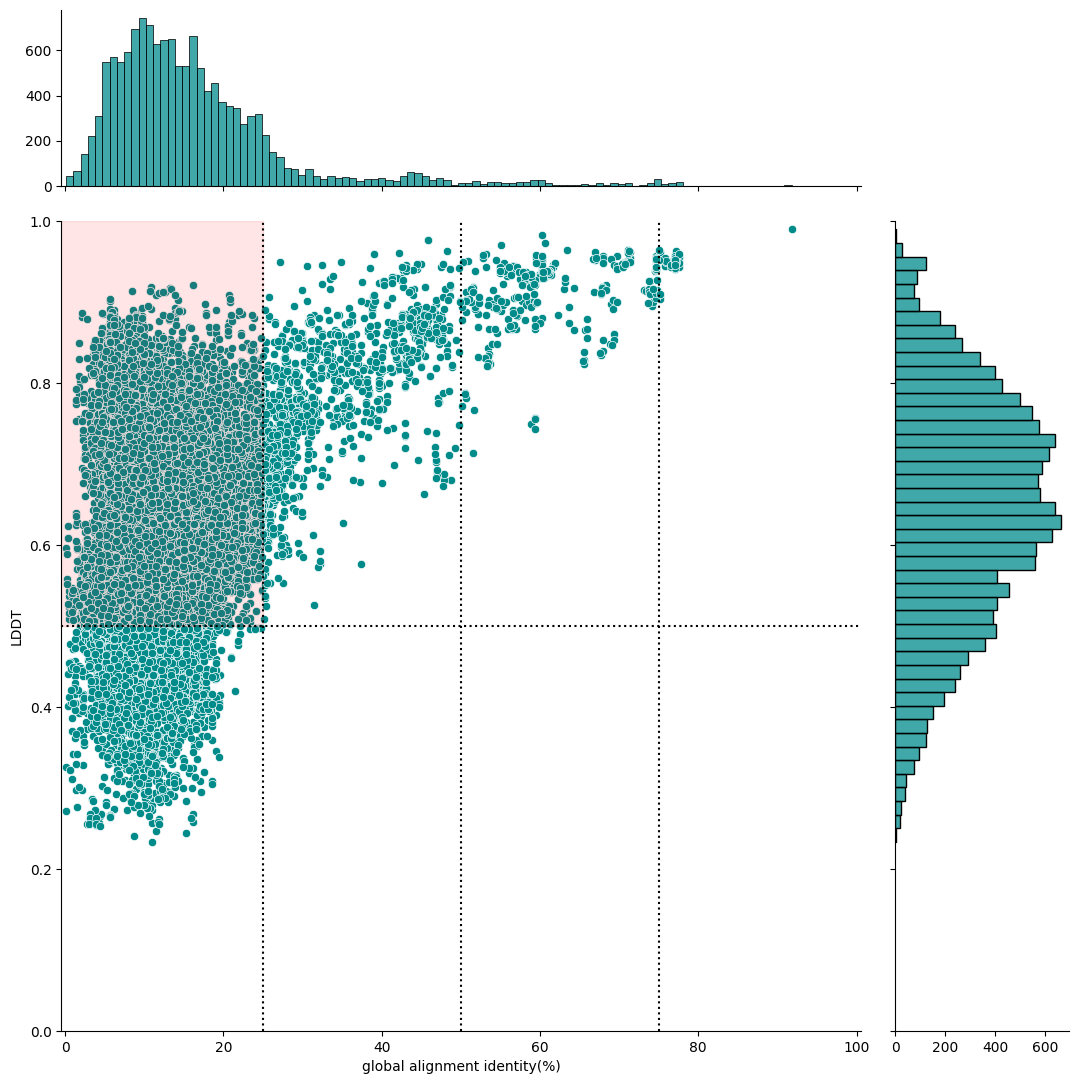

<Figure size 5000x5000 with 0 Axes>

In [17]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=join_foldseek,
    x="Identity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図からレジェンドを削除
# g.legend().remove()

plt.fill_betweenx(
    y=[0.5, 1],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100.5)
plt.ylim(0,1)
plt.xlabel("global alignment identity(%)")
plt.ylabel("LDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")

# レジェンドを別の図として作成
# legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
# legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# legend_ax.axis('off')
# plt.tight_layout()
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

## (発展) 縦軸をカバレッジに変更してみた図

<Figure size 4000x4000 with 0 Axes>

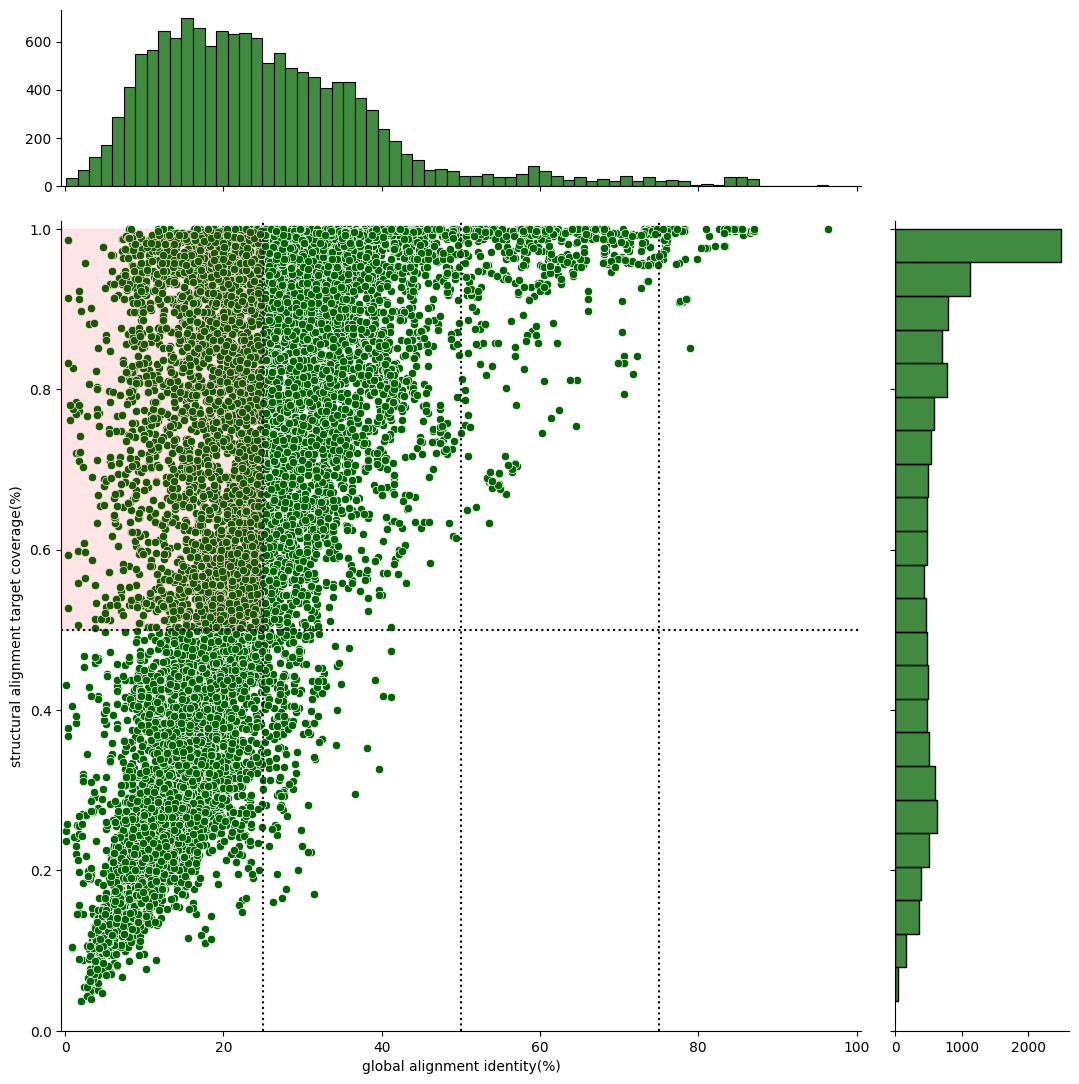

<Figure size 5000x5000 with 0 Axes>

In [18]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=join_foldseek,
    x="Similarity_percent_needle",
    y="tcov",
    color="darkgreen",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図からレジェンドを削除
# g.legend().remove()

plt.fill_betweenx(
    y=[0.5, 1],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100.5)
plt.ylim(0,1.01)
plt.xlabel("global alignment identity(%)")
plt.ylabel("structural alignment target coverage(%)")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")

# レジェンドを別の図として作成
# legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
# legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# legend_ax.axis('off')
# plt.tight_layout()
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;


## Filtering Condition1

- 遺伝子レベルで､foldseekでヒットがないものを選抜する

In [19]:
# 遺伝子レベルでのヒットカウントを算出
all_gene_list = pl.read_csv(
    gene_list_tsv_path,
    separator='\t'
).select(
    "From"
).unique()

hit_count = all_gene_list.join(
    join_foldseek,
    on="From",
    how="left",
    coalesce=True
).group_by("From").agg(
    (pl.col("foldseek hit").count().alias("target hit count (gene level vs uniprot accession)")),
    (pl.col("foldseek hit").is_null().all().alias("foldseek no hit"))
).sort(
    ["target hit count (gene level vs uniprot accession)"], descending=True
)
    
# hit_count.write_csv(
#     "../out/rice_down/foldseek_rice_down_hit_count.tsv",
#     separator='\t'
# )

display(hit_count)

From,target hit count (gene level vs uniprot accession),foldseek no hit
str,u32,bool
"""Os12g0600100""",686,false
"""Os08g0442200""",516,false
"""Os01g0699400""",498,false
"""Os02g0644100""",483,false
"""Os07g0633200""",475,false
…,…,…
"""Os02g0537000""",0,true
"""Os05g0375600""",0,true
"""Os08g0520600""",0,true


In [20]:
no_hit_genes_list = hit_count.filter(
    pl.col("foldseek no hit") == True
)

idmapping_list = pl.read_csv(
    rice_uniprot_idmapping_tsv,
    separator='\t'
)
  
no_hit_idmapping_list = no_hit_genes_list.join(
    idmapping_list,
    on="From",
    how="left"
).sort(
    by=["From"],
    descending=[False]
)

print(no_hit_idmapping_list.group_by(["From"]).n_unique())
display(no_hit_idmapping_list.head())

shape: (210, 4)
┌──────────────┬─────────────────────────────────┬─────────────────┬───────────────────┐
│ From         ┆ target hit count (gene level v… ┆ foldseek no hit ┆ UniProt Accession │
│ ---          ┆ ---                             ┆ ---             ┆ ---               │
│ str          ┆ u32                             ┆ u32             ┆ u32               │
╞══════════════╪═════════════════════════════════╪═════════════════╪═══════════════════╡
│ Os05g0407100 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os04g0607150 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os02g0824500 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os12g0569200 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os08g0518800 ┆ 1                               ┆ 1               ┆ 2                 │
│ …            ┆ …                               ┆ …               ┆ …                 │
│ Os0

From,target hit count (gene level vs uniprot accession),foldseek no hit,UniProt Accession
str,u32,bool,str
"""Os01g0124000""",0,true,"""Q5ZCB1"""
"""Os01g0124000""",0,true,"""Q5ZD53"""
"""Os01g0124100""",0,true,"""A0A0P0UYB2"""
"""Os01g0124100""",0,true,"""Q0JR27"""
"""Os01g0124401""",0,true,"""Q0JR25"""


&nbsp;

&nbsp;

## Filtering Condition2

- 同じ遺伝子由来のUniProt IDに対して､同じtargetのヒットがある場合､qcovが最も高いものを選抜する

In [21]:
condition2 = join_foldseek.sort(
        "qcov", descending=True
    ).unique(
        subset=["From", "foldseek hit"]
    ).sort(
        "qcov", descending=True
    )

print(condition2.group_by(["From"]).n_unique())
display(condition2)

shape: (157, 40)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek  ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit       ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os03g01566 ┆ 2          ┆ 16        ┆ 15     ┆ … ┆ 7         ┆ 14        ┆ 6         ┆ 9         │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os03g04269 ┆ 2          ┆ 15        ┆ 15     ┆ … ┆ 14        ┆ 14       

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os05g0223200""","""Q5TKK2""","""O15187""",5.2640e-9,1.0,3,27.6,0.276,29,1,104,104,39,140,265,105,1.0,0.385,0.8213,0.7515,0.3041,0.3041,12.45,9606,"""Homo sapiens""",72,100,271,"""34/100""","""35/271""",34.0,12.9,50.0,19.9,"""17/100""","""173/271""",17.0,63.8,137.0,130.5
"""Os03g0271400""","""Q0DT33""","""Q8NB74""",0.02812,1.0,22,13.1,0.131,52,1,384,384,293,606,723,395,1.0,0.434,0.5069,0.3164,0.1959,0.1959,31.35,9606,"""Homo sapiens""",251,270,869,"""58/270""","""71/869""",21.5,8.2,31.9,13.8,"""72/270""","""631/869""",26.7,72.6,67.5,60.0
"""Os03g0278800""","""Q10N84""","""A0A6Q8PHA3""",3.1320e-8,1.0,7,20.8,0.208,39,1,173,173,32,212,351,187,1.0,0.516,0.746,0.4479,0.227,0.227,20.05,9606,"""Homo sapiens""",128,154,362,"""40/154""","""42/362""",26.0,11.6,44.8,21.3,"""24/154""","""200/362""",15.6,55.2,124.5,104.0
"""Os03g0278800""","""Q10N84""","""X5DNY3""",2.9360e-8,1.0,5,20.6,0.206,38,1,173,173,75,252,417,184,1.0,0.427,0.785,0.4699,0.203,0.203,22.97,9606,"""Homo sapiens""",129,154,423,"""40/154""","""51/423""",26.0,12.1,44.8,20.3,"""24/154""","""256/423""",15.6,60.5,124.5,111.0
"""Os04g0107900""","""A0A0P0W643""","""Q9H6X9""",0.001593,1.0,3,49.4,0.494,48,1,90,90,270,362,362,97,1.0,0.257,0.6716,0.4872,0.1334,0.1334,20.67,9606,"""Homo sapiens""",38,94,363,"""48/94""","""48/363""",51.1,13.2,71.3,18.5,"""5/94""","""274/363""",5.3,75.5,219.5,219.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os05g0498300""","""Q6L4V0""","""A0A494C0L0""",0.00913,1.0,3,27.3,0.273,26,5,91,809,37,129,131,95,0.108,0.71,0.4151,0.0918,0.5009,0.5009,4.981,9606,"""Homo sapiens""",59,75,846,"""25/75""","""29/846""",33.3,3.4,52.0,5.6,"""1/75""","""752/846""",1.3,88.9,104.0,92.0
"""Os02g0115900""","""Q6Z7B0""","""B4DZP3""",0.01372,1.0,0,47.8,0.478,34,138,208,665,3,73,89,71,0.107,0.798,0.3896,0.1053,0.7504,0.7504,1.214,9606,"""Homo sapiens""",37,70,669,"""34/70""","""36/669""",48.6,5.4,72.9,8.5,"""0/70""","""584/669""",0.0,87.3,180.0,166.5
"""Os08g0500700""","""A0A0P0XIF8""","""Q58FF5""",0.02471,1.0,0,45.8,0.458,33,594,665,694,2,73,74,72,0.104,0.973,0.5606,0.1018,0.8888,0.8888,1.438,9606,"""Homo sapiens""",39,64,695,"""33/64""","""34/695""",51.6,4.9,76.6,7.2,"""0/64""","""622/695""",0.0,89.5,168.0,160.0


&nbsp;

&nbsp;

## Filtering Condition3

- qcovとtcovが0.5以上のものを選抜する

In [22]:
condition3 = condition2.filter(
        (pl.col("qcov") >= 0.5) &
        (pl.col("tcov") >= 0.5)
    ).unique()

condition3_rm = condition2.filter(
        (pl.col("qcov") < 0.5) |
        (pl.col("tcov") < 0.5)
    )

print(condition3.group_by(["From"]).n_unique())
display(condition3)

shape: (151, 40)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek  ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit       ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os04g05380 ┆ 1          ┆ 110       ┆ 98     ┆ … ┆ 69        ┆ 91        ┆ 76        ┆ 84        │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os05g02005 ┆ 1          ┆ 144       ┆ 124    ┆ … ┆ 74        ┆ 110      

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os10g0320100""","""Q7G602""","""Q1H8Y3""",1.3540e-26,1.0,16,24.4,0.244,129,3,518,526,1,483,494,527,0.981,0.978,0.664,0.7561,0.8016,0.8016,5.827,9606,"""Homo sapiens""",343,512,548,"""132/512""","""137/548""",25.8,25.0,43.9,43.1,"""61/512""","""76/548""",11.9,13.9,413.0,412.0
"""Os01g0180800""","""Q9AQZ5""","""O14992""",1.0390e-51,1.0,4,46.0,0.46,208,1,448,845,1,451,474,452,0.53,0.951,0.8551,0.5222,0.9251,0.9251,1.278,9606,"""Homo sapiens""",239,456,854,"""209/456""","""211/854""",45.8,24.7,62.9,34.1,"""4/456""","""389/854""",0.9,45.6,1030.5,1025.0
"""Os06g0698300""","""A0A0N7KMN4""","""A8K599""",2.1930e-23,1.0,12,30.1,0.301,89,11,270,287,12,295,387,295,0.906,0.734,0.7699,0.8108,0.6068,0.6068,2.629,9606,"""Homo sapiens""",160,323,407,"""101/323""","""102/407""",31.3,25.1,44.9,36.9,"""62/323""","""140/407""",19.2,34.4,336.5,327.0
"""Os03g0271400""","""Q0DT33""","""G3V126""",0.06552,1.0,17,11.2,0.112,38,27,314,384,1,312,443,337,0.75,0.704,0.5137,0.4967,0.44,0.44,8.699,9606,"""Homo sapiens""",225,170,717,"""30/170""","""32/717""",17.6,4.5,32.9,8.4,"""71/170""","""607/717""",41.8,84.7,54.0,44.0
"""Os05g0200500""","""B7EKD2""","""U3KQB3""",7.4620e-28,1.0,11,28.5,0.285,108,1,366,607,9,362,475,378,0.603,0.745,0.6779,0.4415,0.5596,0.5596,22.3,9606,"""Homo sapiens""",234,457,683,"""128/457""","""135/683""",28.0,19.8,45.3,31.8,"""84/457""","""284/683""",18.4,41.6,459.0,438.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os05g0129900""","""A0A0P0WHI2""","""B3KVW1""",0.001101,1.0,11,12.5,0.125,47,39,383,397,131,412,531,374,0.869,0.531,0.5414,0.2516,0.1908,0.1908,24.31,9606,"""Homo sapiens""",206,203,673,"""43/203""","""78/673""",21.2,11.6,37.9,18.6,"""52/203""","""418/673""",25.6,62.1,98.0,79.5
"""Os04g0538000""","""A0A0P0WD35""","""Q8TAM2""",0.000002,1.0,10,9.1,0.091,44,54,531,607,235,536,541,479,0.787,0.558,0.6434,0.1858,0.2078,0.2078,19.08,9606,"""Homo sapiens""",257,452,771,"""87/452""","""101/771""",19.2,13.1,30.5,22.7,"""164/452""","""394/771""",36.3,51.1,90.5,70.0
"""Os07g0549800""","""A3BKY1""","""D6RAF8""",2.3010e-8,1.0,2,22.8,0.228,32,1,133,133,56,194,221,140,1.0,0.629,0.7606,0.632,0.3956,0.3956,15.85,9606,"""Homo sapiens""",100,87,249,"""34/87""","""39/249""",39.1,15.7,58.6,24.5,"""5/87""","""144/249""",5.7,57.8,137.5,118.0


&nbsp;

&nbsp;


## Filtering Condition4

- TogoIDでEnsembl gene idに変換できるヒットを選抜する
- おそらく1つのUniProt IDに対して，複数のgene IDが対応している可能性がある

In [23]:
# !bash ../scripts/togoid_convert.sh ../out/rice_up/uniprot_id_human_up.txt ../out/rice_up/ uniprot,ensembl_protein,ensembl_transcript,ensembl_gene,hgnc,hgnc_symbol rice_up_togoid_convert.tsv


In [24]:
togoid_convert = pl.read_csv(
    togoid_convert_tsv_path,
    separator='\t'
).rename(
    {
        "uniprot_id" : "foldseek hit"
    }
).filter(
    pl.col("ensembl_gene_id").is_not_null()
)

display(togoid_convert)

foldseek hit,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id
str,str,str,str,i64,str
"""A0A024QZW4""","""ENSP00000518269""","""ENST00000710437""","""ENSG00000124786""",21601,"""SLC35B3"""
"""A0A024QZW4""","""ENSP00000498054""","""ENST00000648987""","""ENSG00000124786""",21601,"""SLC35B3"""
"""A0A024R3B9""","""ENSP00000435411""","""ENST00000525823""","""ENSG00000109846""",2389,"""CRYAB"""
"""A0A024R3B9""","""ENSP00000435960""","""ENST00000528961""","""ENSG00000109846""",2389,"""CRYAB"""
"""A0A024R3B9""","""ENSP00000435046""","""ENST00000533280""","""ENSG00000109846""",2389,"""CRYAB"""
…,…,…,…,…,…
"""X6RA14""","""ENSP00000367969""","""ENST00000378697""","""ENSG00000139684""",3465,"""ESD"""
"""X6RBJ8""","""ENSP00000380187""","""ENST00000396990""","""ENSG00000198876""",19911,"""DCAF12"""
"""X6RHX1""","""ENSP00000407993""","""ENST00000423670""","""ENSG00000000457""",19285,"""SCYL3"""


In [25]:
condition4 = condition3.join(
    togoid_convert,
    on="foldseek hit",
    how="left",
    coalesce=True
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).group_by(
    pl.exclude( # 異なるensembl_protein_idとensembl_transcript_idを持つために増えてしまった行をリスト化することで行数を減らす
        [
            "hgnc_id", "hgnc_symbol_id", "ensembl_gene_id", "ensembl_protein_id", "ensembl_transcript_id"
        ]
    )
).agg(
    pl.col("hgnc_id"),
    pl.col("hgnc_symbol_id"),
    pl.col("ensembl_gene_id"),
    pl.col("ensembl_protein_id"),
    pl.col("ensembl_transcript_id"),
).drop(
    [
        "hgnc_id",
        "ensembl_transcript_id"
    ]
).sort(
    by=["From"],
    descending=[False]
)

#print(condition4.group_by(["From", "UniProt Accession", "foldseek hit"]).n_unique())
display(condition4)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str]
"""Os01g0105800""","""Q657Z2""","""Q5TBE9""",0.000019,1.0,1,42.8,0.428,36,4,86,138,2,85,86,84,0.601,0.977,0.6491,0.4395,0.6864,0.6864,11.51,9606,"""Homo sapiens""",47,81,141,"""37/81""","""37/141""",45.7,26.2,63.0,36.2,"""6/81""","""58/141""",7.4,41.1,154.5,153.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365157""]"
"""Os01g0105800""","""Q657Z2""","""Q9BUE6""",9.1120e-13,1.0,1,51.6,0.516,64,4,126,138,2,125,129,124,0.891,0.961,0.8839,0.7278,0.7768,0.7768,11.57,9606,"""Homo sapiens""",59,128,141,"""67/128""","""67/141""",52.3,47.5,67.2,61.0,"""5/128""","""15/141""",3.9,10.6,316.5,312.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365159""]"
"""Os01g0105800""","""Q657Z2""","""A0A1B0GTK6""",2.9110e-9,1.0,1,48.3,0.483,43,27,114,138,4,92,92,89,0.638,0.967,0.841,0.6203,0.9193,0.9193,0.88,9606,"""Homo sapiens""",45,87,141,"""44/87""","""44/141""",50.6,31.2,70.1,43.3,"""5/87""","""52/141""",5.7,36.9,211.5,206.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000489740""]"
"""Os01g0105800""","""Q657Z2""","""Q86U28""",2.6130e-8,1.0,3,29.8,0.298,37,4,125,138,27,147,154,124,0.884,0.786,0.7242,0.6192,0.5619,0.5619,8.441,9606,"""Homo sapiens""",82,126,162,"""39/126""","""39/162""",31.0,24.1,50.8,39.5,"""3/126""","""32/162""",2.4,19.8,164.5,154.5,"[""ISCA2"", ""ISCA2""]","[""ENSG00000165898"", ""ENSG00000165898""]","[""ENSP00000450523"", ""ENSP00000452007""]"
"""Os01g0135800""","""Q943Q3""","""O14558""",0.01643,1.0,8,18.9,0.189,31,3,145,150,12,160,160,164,0.953,0.931,0.5166,0.4431,0.4175,0.4175,16.35,9606,"""Homo sapiens""",97,119,176,"""30/119""","""35/176""",25.2,19.9,42.9,34.1,"""13/119""","""42/176""",10.9,23.9,71.0,63.0,"[""HSPB6""]","[""ENSG00000004776""]","[""ENSP00000004982""]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0600100""","""Q0IM43""","""Q9Y575""",4.1220e-10,1.0,21,17.6,0.176,91,8,386,387,13,506,518,516,0.979,0.954,0.5381,0.4101,0.3225,0.3225,22.4,9606,"""Homo sapiens""",266,272,596,"""84/272""","""110/596""",30.9,18.5,48.5,28.0,"""49/272""","""287/596""",18.0,48.2,275.5,266.0,"[""ASB3"", ""ASB3"", … ""ASB3""]","[""ENSG00000115239"", ""ENSG00000115239"", … ""ENSG00000115239""]","[""ENSP00000263634"", ""ENSP00000378206"", … ""ENSP00000384728""]"
"""Os12g0600100""","""Q0IM43""","""H7C209""",2.3270e-8,1.0,20,18.3,0.183,87,9,382,387,40,471,791,474,0.966,0.546,0.5753,0.5132,0.2568,0.2568,14.99,9606,"""Homo sapiens""",245,427,848,"""100/427""","""112/848""",23.4,13.2,36.3,19.9,"""114/427""","""518/848""",26.7,61.1,230.5,217.5,"[""ANKRD44""]","[""ENSG00000065413""]","[""ENSP00000403415""]"
"""Os12g0600100""","""Q2QML3""","""A0A3B3ITU5""",4.7260e-7,1.0,7,22.3,0.223,62,9,260,387,84,339,455,278,0.651,0.563,0.6766,0.5119,0.4378,0.4378,8.868,9606,"""Homo sapiens""",168,354,588,"""90/354""","""86/588""",25.4,14.6,38.1,23.0,"""93/354""","""334/588""",26.3,56.8,197.0,178.5,"[""ANKS1A""]","[""ENSG00000064999""]","[""ENSP00000497939""]"


In [26]:
hit_count_condition4 = condition4.group_by(
    ["From"]
).agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    by=["hit count (gene level)"],
    descending=True
)

display(hit_count_condition4)

From,hit count (gene level)
str,u32
"""Os07g0633200""",94
"""Os05g0200500""",93
"""Os01g0699400""",88
"""Os06g0697200""",86
"""Os04g0185600""",84
…,…
"""Os05g0367000""",1
"""Os04g0136700""",1
"""Os03g0156600""",1


In [27]:
foldseek_filter_viz = condition4.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water"
).unique(
    subset=["From", "UniProt Accession", "foldseek hit"]
).sort(
    by=["From"],
    descending=[False]
)

print(foldseek_filter_viz.group_by(["From", "UniProt Accession", "foldseek hit"]).n_unique())
display(foldseek_filter_viz)

shape: (2_946, 11)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ qcov ┆ … ┆ Identity_p ┆ Identity_ ┆ Similarit ┆ Similarit │
│ ---        ┆ Accession  ┆ hit        ┆ ---  ┆   ┆ ercent_nee ┆ percent_w ┆ y_percent ┆ y_percent │
│ str        ┆ ---        ┆ ---        ┆ u32  ┆   ┆ dle        ┆ ater      ┆ _needle   ┆ _water    │
│            ┆ str        ┆ str        ┆      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆ u32        ┆ u32       ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Os02g07109 ┆ Q0DY76     ┆ A0A7I2V2S7 ┆ 1    ┆ … ┆ 1          ┆ 1         ┆ 1         ┆ 1         │
│ 00         ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ Os05g05623 ┆ B9FI44     ┆ C9JRD2     ┆ 1    ┆ … ┆ 1          ┆ 1      

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""Os01g0105800""","""Q657Z2""","""Q5TBE9""",0.601,0.977,11.51,0.6491,26.2,45.7,36.2,63.0
"""Os01g0105800""","""Q657Z2""","""Q86U28""",0.884,0.786,8.441,0.7242,24.1,31.0,39.5,50.8
"""Os01g0105800""","""Q657Z2""","""A0A1B0GTK6""",0.638,0.967,0.88,0.841,31.2,50.6,43.3,70.1
"""Os01g0105800""","""Q657Z2""","""Q9BUE6""",0.891,0.961,11.57,0.8839,47.5,52.3,61.0,67.2
"""Os01g0135800""","""Q943Q3""","""P04792""",0.993,0.663,15.31,0.6507,16.9,24.4,27.4,40.4
…,…,…,…,…,…,…,…,…,…,…
"""Os12g0600100""","""Q2QML3""","""Q92527""",0.659,0.858,7.21,0.6448,17.4,30.7,30.3,48.7
"""Os12g0600100""","""Q2QML3""","""H7C4A0""",0.589,0.93,5.062,0.6492,18.8,28.3,28.5,41.8
"""Os12g0600100""","""Q0IM43""","""P50542""",0.969,0.531,22.18,0.4569,9.7,22.1,16.9,41.4


<Figure size 4000x4000 with 0 Axes>

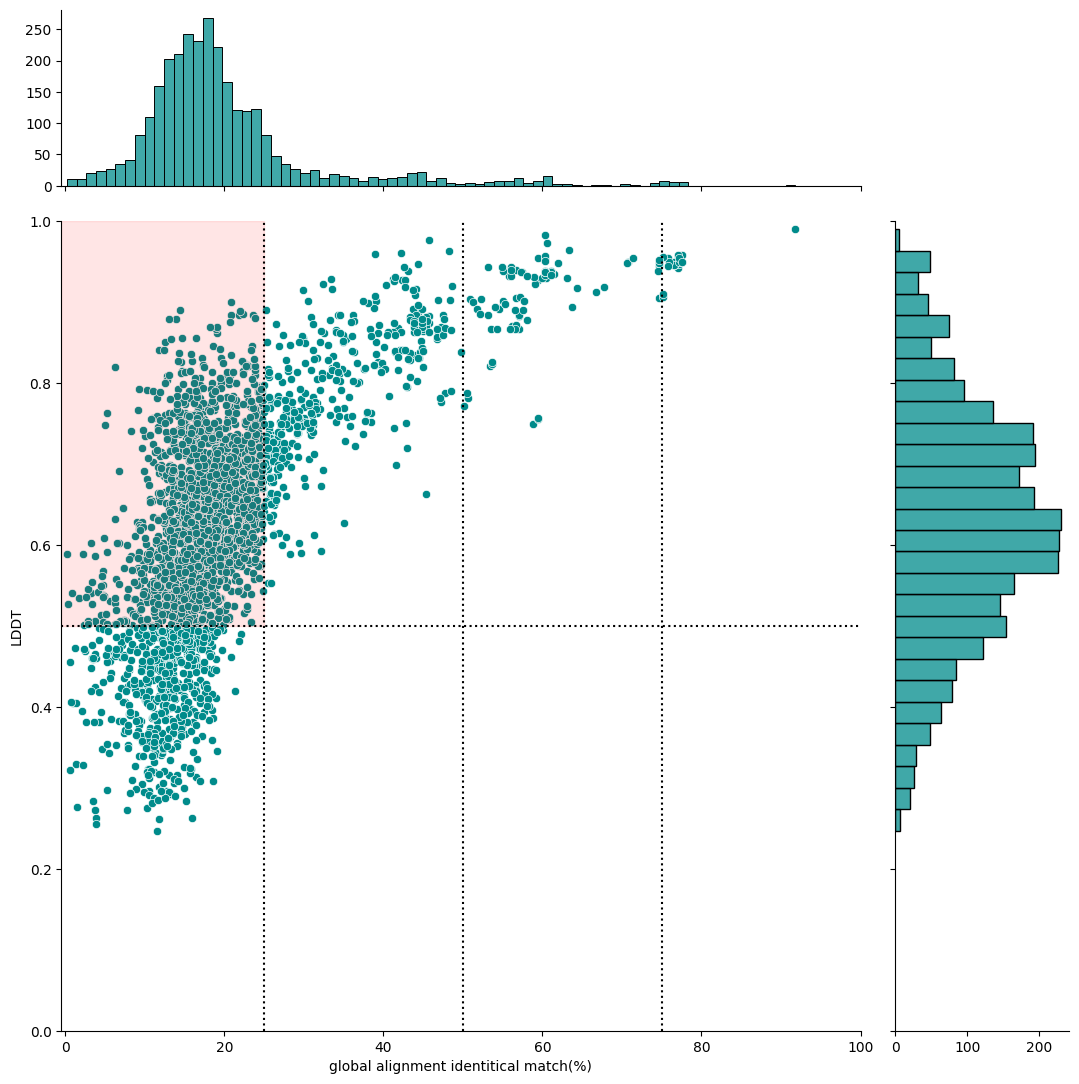

<Figure size 5000x5000 with 0 Axes>

In [28]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=foldseek_filter_viz,
    x="Identity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.fill_betweenx(
    y=[0.5, 1],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("global alignment identitical match(%)")
plt.ylabel("LDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

In [29]:
condition4_filter_1 = condition4.filter(
    (pl.col("lddt") >= 0.5) &
    (pl.col("Identity_percent_needle") > 25)
)

display(condition4_filter_1)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str]
"""Os01g0105800""","""Q657Z2""","""Q5TBE9""",0.000019,1.0,1,42.8,0.428,36,4,86,138,2,85,86,84,0.601,0.977,0.6491,0.4395,0.6864,0.6864,11.51,9606,"""Homo sapiens""",47,81,141,"""37/81""","""37/141""",45.7,26.2,63.0,36.2,"""6/81""","""58/141""",7.4,41.1,154.5,153.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365157""]"
"""Os01g0105800""","""Q657Z2""","""Q9BUE6""",9.1120e-13,1.0,1,51.6,0.516,64,4,126,138,2,125,129,124,0.891,0.961,0.8839,0.7278,0.7768,0.7768,11.57,9606,"""Homo sapiens""",59,128,141,"""67/128""","""67/141""",52.3,47.5,67.2,61.0,"""5/128""","""15/141""",3.9,10.6,316.5,312.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365159""]"
"""Os01g0105800""","""Q657Z2""","""A0A1B0GTK6""",2.9110e-9,1.0,1,48.3,0.483,43,27,114,138,4,92,92,89,0.638,0.967,0.841,0.6203,0.9193,0.9193,0.88,9606,"""Homo sapiens""",45,87,141,"""44/87""","""44/141""",50.6,31.2,70.1,43.3,"""5/87""","""52/141""",5.7,36.9,211.5,206.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000489740""]"
"""Os01g0180800""","""Q9AQZ5""","""O95757""",7.0670e-82,1.0,10,38.7,0.387,327,1,837,845,1,839,839,846,0.991,1.0,0.892,0.8487,0.8546,0.8546,10.9,9606,"""Homo sapiens""",503,869,877,"""340/869""","""340/877""",39.1,38.8,58.1,57.6,"""62/869""","""70/877""",7.1,8.0,1564.0,1564.0,"[""HSPA4L"", ""HSPA4L""]","[""ENSG00000164070"", ""ENSG00000164070""]","[""ENSP00000296464"", ""ENSP00000422482""]"
"""Os01g0180800""","""Q9AQZ5""","""D6RJ96""",6.6930e-52,1.0,7,37.2,0.372,214,1,570,845,1,530,531,575,0.675,0.998,0.8072,0.5358,0.8451,0.8451,16.28,9606,"""Homo sapiens""",311,586,854,"""219/586""","""219/854""",37.4,25.6,56.7,38.9,"""65/586""","""332/854""",11.1,38.9,1019.5,1016.5,"[""HSPA4L""]","[""ENSG00000164070""]","[""ENSP00000427305""]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0270900""","""Q2QU81""","""O00338""",2.0760e-17,1.0,13,29.4,0.294,89,48,338,338,11,293,296,302,0.861,0.956,0.6712,0.7374,0.8364,0.8364,2.791,9606,"""Homo sapiens""",183,304,354,"""95/304""","""97/354""",31.2,27.4,49.7,43.5,"""34/304""","""74/354""",11.2,20.9,365.5,361.0,"[""SULT1C2"", ""SULT1C2""]","[""ENSG00000198203"", ""ENSG00000198203""]","[""ENSP00000319622"", ""ENSP00000251481""]"
"""Os12g0270900""","""Q2QU81""","""P50226""",2.2000e-16,1.0,16,28.3,0.283,85,50,338,338,12,292,295,300,0.855,0.953,0.6637,0.7332,0.8344,0.8344,2.785,9606,"""Homo sapiens""",185,299,352,"""91/299""","""91/352""",30.4,25.9,49.5,42.9,"""30/299""","""71/352""",10.0,20.2,308.5,302.5,"[""SULT1A2"", ""SULT1A2""]","[""ENSG00000197165"", ""ENSG00000197165""]","[""ENSP00000338742"", ""ENSP00000378992""]"
"""Os12g0270900""","""Q2QU81""","""Q6IMI4""",2.6030e-14,1.0,15,26.1,0.261,83,25,332,338,1,288,303,318,0.911,0.95,0.6123,0.6825,0.7559,0.7559,5.686,9606,"""Homo sapiens""",195,319,364,"""92/319""","""95/364""",28.8,26.1,43.9,39.6,"""53/319""","""87/364""",16.6,23.9,262.0,255.0,"[""SULT6B1""]","[""ENSG00000138068""]","[""ENSP00000444081""]"


In [30]:
condition4_filter = condition4.filter(
    (pl.col("lddt") >= 0.5) &
    (pl.col("Identity_percent_needle") <= 25) &
    (~pl.col("From").is_in(condition4_filter_1.select("From"))) # 条件1 (LDDT ≧ 0.5 & Identity > 25%) を除外
)

display(condition4_filter)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str]
"""Os01g0135800""","""Q943Q3""","""O14558""",0.01643,1.0,8,18.9,0.189,31,3,145,150,12,160,160,164,0.953,0.931,0.5166,0.4431,0.4175,0.4175,16.35,9606,"""Homo sapiens""",97,119,176,"""30/119""","""35/176""",25.2,19.9,42.9,34.1,"""13/119""","""42/176""",10.9,23.9,71.0,63.0,"[""HSPB6""]","[""ENSG00000004776""]","[""ENSP00000004982""]"
"""Os01g0135800""","""Q943Q3""","""Q8N241""",0.004888,1.0,6,16.9,0.169,26,1,148,150,122,245,245,153,0.987,0.506,0.5821,0.4587,0.2914,0.2914,16.01,9606,"""Homo sapiens""",93,37,281,"""16/37""","""30/281""",43.2,10.7,45.9,19.2,"""9/37""","""167/281""",24.3,59.4,42.0,32.0,"[""HSPB7""]","[""ENSG00000173641""]","[""ENSP00000364870""]"
"""Os01g0135800""","""Q943Q3""","""P02511""",0.0001032,1.0,9,21.6,0.216,32,12,150,150,39,163,175,148,0.927,0.714,0.6295,0.5113,0.4427,0.4427,9.355,9606,"""Homo sapiens""",84,97,194,"""30/97""","""39/194""",30.9,20.1,52.6,35.6,"""17/97""","""63/194""",17.5,32.5,91.0,80.5,"[""CRYAB"", ""CRYAB"", … ""CRYAB""]","[""ENSG00000109846"", ""ENSG00000109846"", … ""ENSG00000109846""]","[""ENSP00000227251"", ""ENSP00000436051"", … ""ENSP00000499082""]"
"""Os01g0135800""","""Q943Q3""","""Q9UBY9""",0.001166,1.0,8,15.2,0.152,24,1,149,150,36,169,170,157,0.993,0.788,0.5838,0.4956,0.4414,0.4414,24.09,9606,"""Homo sapiens""",102,148,206,"""29/148""","""30/206""",19.6,14.6,34.5,26.2,"""41/148""","""92/206""",27.7,44.7,37.5,32.0,"[""HSPB7"", ""HSPB7""]","[""ENSG00000173641"", ""ENSG00000173641""]","[""ENSP00000310111"", ""ENSP00000419477""]"
"""Os01g0135800""","""Q943Q3""","""E9PHZ2""",0.01393,1.0,5,12.8,0.128,19,16,148,150,16,144,144,148,0.887,0.896,0.5943,0.4676,0.4856,0.4856,15.06,9606,"""Homo sapiens""",95,79,187,"""19/79""","""29/187""",24.1,15.5,45.6,29.4,"""13/79""","""80/187""",16.5,42.8,36.0,27.0,"[""CHORDC1"", ""CHORDC1"", … ""CHORDC1""]","[""ENSG00000285023"", ""ENSG00000285023"", … ""ENSG00000110172""]","[""ENSP00000495780"", ""ENSP00000494250"", … ""ENSP00000436632""]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0600100""","""Q2QML3""","""E9PP91""",5.3860e-9,1.0,16,18.4,0.184,70,9,370,387,30,360,502,379,0.935,0.659,0.6046,0.526,0.4095,0.4095,25.53,9606,"""Homo sapiens""",244,198,569,"""57/198""","""97/569""",28.8,17.0,46.5,27.8,"""15/198""","""249/569""",7.6,43.8,205.5,187.0,"[""ANKRD42""]","[""ENSG00000137494""]","[""ENSP00000434666""]"
"""Os12g0600100""","""Q0IM43""","""Q9Y575""",4.1220e-10,1.0,21,17.6,0.176,91,8,386,387,13,506,518,516,0.979,0.954,0.5381,0.4101,0.3225,0.3225,22.4,9606,"""Homo sapiens""",266,272,596,"""84/272""","""110/596""",30.9,18.5,48.5,28.0,"""49/272""","""287/596""",18.0,48.2,275.5,266.0,"[""ASB3"", ""ASB3"", … ""ASB3""]","[""ENSG00000115239"", ""ENSG00000115239"", … ""ENSG00000115239""]","[""ENSP00000263634"", ""ENSP00000378206"", … ""ENSP00000384728""]"
"""Os12g0600100""","""Q0IM43""","""H7C209""",2.3270e-8,1.0,20,18.3,0.183,87,9,382,387,40,471,791,474,0.966,0.546,0.5753,0.5132,0.2568,0.2568,14.99,9606,"""Homo sapiens""",245,427,848,"""100/427""","""112/848""",23.4,13.2,36.3,19.9,"""114/427""","""518/848""",26.7,61.1,230.5,217.5,"[""ANKRD44""]","[""ENSG00000065413""]","[""ENSP00000403415""]"


&nbsp;

&nbsp;

&nbsp;

## Custom Analysis: Domain Information

In [31]:
# rice domain information
uniprot_info_rice = pl.read_csv(
    query_idmapping_tsv_path,
    separator='\t'
)

domain_info_rice = uniprot_info_rice.select(
    "From",
    "InterPro"
).rename(
    {
        "From": "UniProt Accession",
        "InterPro": "InterPro_rice"
    }
).with_columns(
    pl.col("InterPro_rice").str.strip_suffix(";")
).with_columns(
    pl.col("InterPro_rice").str.split(";").cast(pl.List(pl.Utf8))
)

# human domain information
uniprot_info_human = pl.read_csv(
    target_idmapping_tsv_path,
    separator='\t'
)

domain_info_human = uniprot_info_human.select(
    "From",
    "InterPro"
).rename(
    {
        "From": "foldseek hit",
        "InterPro": "InterPro_human"
    }
).with_columns(
    pl.col("InterPro_human").str.strip_suffix(";")
).with_columns(
    pl.col("InterPro_human").str.split(";").cast(pl.List(pl.Utf8))
)

display(domain_info_rice)
display(domain_info_human)

UniProt Accession,InterPro_rice
str,list[str]
"""A0A8J8YF34""","[""IPR050322"", ""IPR000361"", … ""IPR035903""]"
"""Q657Z2""","[""IPR050322"", ""IPR000361"", … ""IPR035903""]"
"""Q5ZCB1""","[""IPR035995"", ""IPR000877""]"
"""Q5ZD53""","[""IPR035995"", ""IPR000877""]"
"""A0A0P0UYB2""","[""IPR035995"", ""IPR000877""]"
…,…
"""Q2QND9""",null
"""Q0IM43""","[""IPR002110"", ""IPR036770"", … ""IPR019734""]"
"""Q2QML3""","[""IPR002110"", ""IPR036770"", … ""IPR019734""]"


foldseek hit,InterPro_human
str,list[str]
"""Q9BUE6""","[""IPR050322"", ""IPR000361"", … ""IPR035903""]"
"""A0A1B0GTK6""","[""IPR050322"", ""IPR000361"", … ""IPR035903""]"
"""Q86U28""","[""IPR000361"", ""IPR016092"", … ""IPR035903""]"
"""Q5TBE9""","[""IPR050322"", ""IPR000361"", ""IPR035903""]"
"""A0A140G945""","[""IPR002068"", ""IPR001436"", … ""IPR008978""]"
…,…
"""B4DXL6""","[""IPR051637"", ""IPR002110"", ""IPR036770""]"
"""F2Z2L2""","[""IPR002110"", ""IPR036770"", … ""IPR043145""]"
"""Q5H9P4""","[""IPR049764"", ""IPR002110"", … ""IPR013083""]"


In [32]:
domain_info = foldseek_filter_viz.join(
    domain_info_rice,
    on="UniProt Accession",
    how="left",
    coalesce=True,
    validate="m:m"
).join(
    domain_info_human,
    on="foldseek hit",
    how="left",
    coalesce=True,
    validate="m:m"
).with_columns(
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").alias("InterPro ID intersection"),
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").list.len().alias("InterPro ID intersection count")
).sort(
    by=["InterPro ID intersection count"],
    descending=[True]
).with_columns(
    pl.when(
        (pl.col("InterPro_rice").is_null()) | (pl.col("InterPro_human").is_null())
    ).then(
        pl.lit("missing InterPro entry in rice or human")
    ).when(
        pl.col("InterPro ID intersection count") == 0
    ).then(
        pl.lit("no common InterPro ID")
    ).otherwise(
        pl.lit("have common InterPro ID")
    ).alias("InterPro ID intersection tag")
)

display(domain_info)

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,list[str],list[str],list[str],u32,str
"""Os09g0558900""","""Q653S9""","""P16435""",1.0,0.999,10.96,0.7596,36.0,39.6,53.1,59.1,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",11,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""P29474""",0.86,0.536,4.284,0.7331,19.0,28.4,29.1,43.3,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""Q9UHB4""",0.856,0.992,4.516,0.7489,27.1,31.1,42.2,48.5,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""P35228""",0.86,0.515,7.092,0.73,18.4,30.9,28.0,46.5,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""E7ESA7""",0.859,0.646,5.625,0.7357,22.8,28.4,34.8,43.3,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os10g0537500""","""B9G6S6""","""A0A3B3ITN8""",0.888,0.791,7.579,0.4556,14.5,18.2,28.2,36.0,"[""IPR040226"", ""IPR009457""]","[""IPR017978"", ""IPR051753""]",[],0,"""no common InterPro ID"""
"""Os10g0537500""","""B9G6S6""","""Q96N19""",0.898,0.707,5.318,0.5886,16.0,21.9,26.9,38.6,"[""IPR040226"", ""IPR009457""]","[""IPR029723""]",[],0,"""no common InterPro ID"""
"""Os11g0594500""","""Q2R1S8""","""K7EIS6""",0.716,0.793,13.67,0.2556,3.9,20.8,6.9,31.5,"[""IPR005174""]","[""IPR040371"", ""IPR049040"", … ""IPR036322""]",[],0,"""no common InterPro ID"""


In [33]:
have_domain_info = domain_info.filter(
    (pl.col("InterPro ID intersection tag") == "have common InterPro ID")
)

display(have_domain_info)

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,list[str],list[str],list[str],u32,str
"""Os09g0558900""","""Q653S9""","""P16435""",1.0,0.999,10.96,0.7596,36.0,39.6,53.1,59.1,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",11,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""P29474""",0.86,0.536,4.284,0.7331,19.0,28.4,29.1,43.3,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""Q9UHB4""",0.856,0.992,4.516,0.7489,27.1,31.1,42.2,48.5,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""P35228""",0.86,0.515,7.092,0.73,18.4,30.9,28.0,46.5,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
"""Os09g0558900""","""Q653S9""","""E7ESA7""",0.859,0.646,5.625,0.7357,22.8,28.4,34.8,43.3,"[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]","[""IPR003097"", ""IPR017927"", … ""IPR017938""]",10,"""have common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0478200""","""A0A0P0Y9Z0""","""E5RK11""",0.753,0.943,4.072,0.6326,15.3,33.3,21.8,45.2,"[""IPR037848"", ""IPR004182"", ""IPR011993""]","[""IPR030564"", ""IPR011993""]","[""IPR011993""]",1,"""have common InterPro ID"""
"""Os12g0478200""","""C7JA48""","""Q9H8W4""",0.904,0.514,6.404,0.5892,2.2,63.6,3.8,81.8,"[""IPR037848"", ""IPR004182"", ""IPR011993""]","[""IPR011993"", ""IPR001849"", … ""IPR013083""]","[""IPR011993""]",1,"""have common InterPro ID"""
"""Os12g0478200""","""C7JA48""","""Q53GA4""",0.863,0.789,5.711,0.6099,18.9,28.2,26.8,38.0,"[""IPR037848"", ""IPR004182"", ""IPR011993""]","[""IPR011993"", ""IPR001849"", ""IPR042832""]","[""IPR011993""]",1,"""have common InterPro ID"""


In [34]:
no_domain_info = domain_info.filter(
    ((pl.col("InterPro ID intersection tag") == "missing InterPro entry in rice or human") |
    (pl.col("InterPro ID intersection tag") == "no common InterPro ID")) &
    (~pl.col("From").is_in(have_domain_info.select("From")))
).sort(
    by=["lddt"],
    descending=[True]
)

display(no_domain_info)

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,list[str],list[str],list[str],u32,str
"""Os03g0817100""","""B9F6Z0""","""P21145""",0.717,0.837,2.355,0.698,16.6,29.1,27.1,45.5,"[""IPR006702""]","[""IPR013295"", ""IPR008253"", ""IPR050578""]",[],0,"""no common InterPro ID"""
"""Os03g0817100""","""B9F6Z0""","""Q13021""",0.692,0.804,2.601,0.6862,19.6,22.5,28.9,33.3,"[""IPR006702""]","[""IPR013295"", ""IPR008253"", ""IPR050578""]",[],0,"""no common InterPro ID"""
"""Os07g0675200""","""C7J4R2""","""A0A044PY82""",1.0,0.895,37.36,0.6468,15.6,21.8,24.4,34.5,null,"[""IPR029304"", ""IPR042779""]",null,0,"""missing InterPro entry in rice…"
"""Os03g0817100""","""B9F6Z0""","""O95473""",0.833,0.722,7.417,0.6457,13.7,21.0,24.7,35.8,"[""IPR006702""]","[""IPR008253"", ""IPR016579""]",[],0,"""no common InterPro ID"""
"""Os08g0546400""","""Q6ZFV9""","""H0YI14""",0.919,0.76,54.37,0.64,13.2,18.4,23.7,32.6,"[""IPR009060"", ""IPR029071"", … ""IPR003903""]","[""IPR003593"", ""IPR003959"", … ""IPR027417""]",[],0,"""no common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os10g0537500""","""B9G6S6""","""P33032""",0.837,0.815,5.718,0.4513,15.3,20.3,30.9,36.9,"[""IPR040226"", ""IPR009457""]","[""IPR000276"", ""IPR017452"", … ""IPR001671""]",[],0,"""no common InterPro ID"""
"""Os03g0727800""","""Q6ATI4""","""Q5QP82""",0.763,0.512,22.86,0.3969,14.1,24.8,18.5,33.4,"[""IPR036047"", ""IPR001810""]","[""IPR039085"", ""IPR015943"", … ""IPR001680""]",[],0,"""no common InterPro ID"""
"""Os11g0594500""","""Q2R1S8""","""Q8IY47""",0.949,0.602,17.47,0.2955,12.0,22.3,19.2,33.8,"[""IPR005174""]","[""IPR011705"", ""IPR017096"", … ""IPR011333""]",[],0,"""no common InterPro ID"""


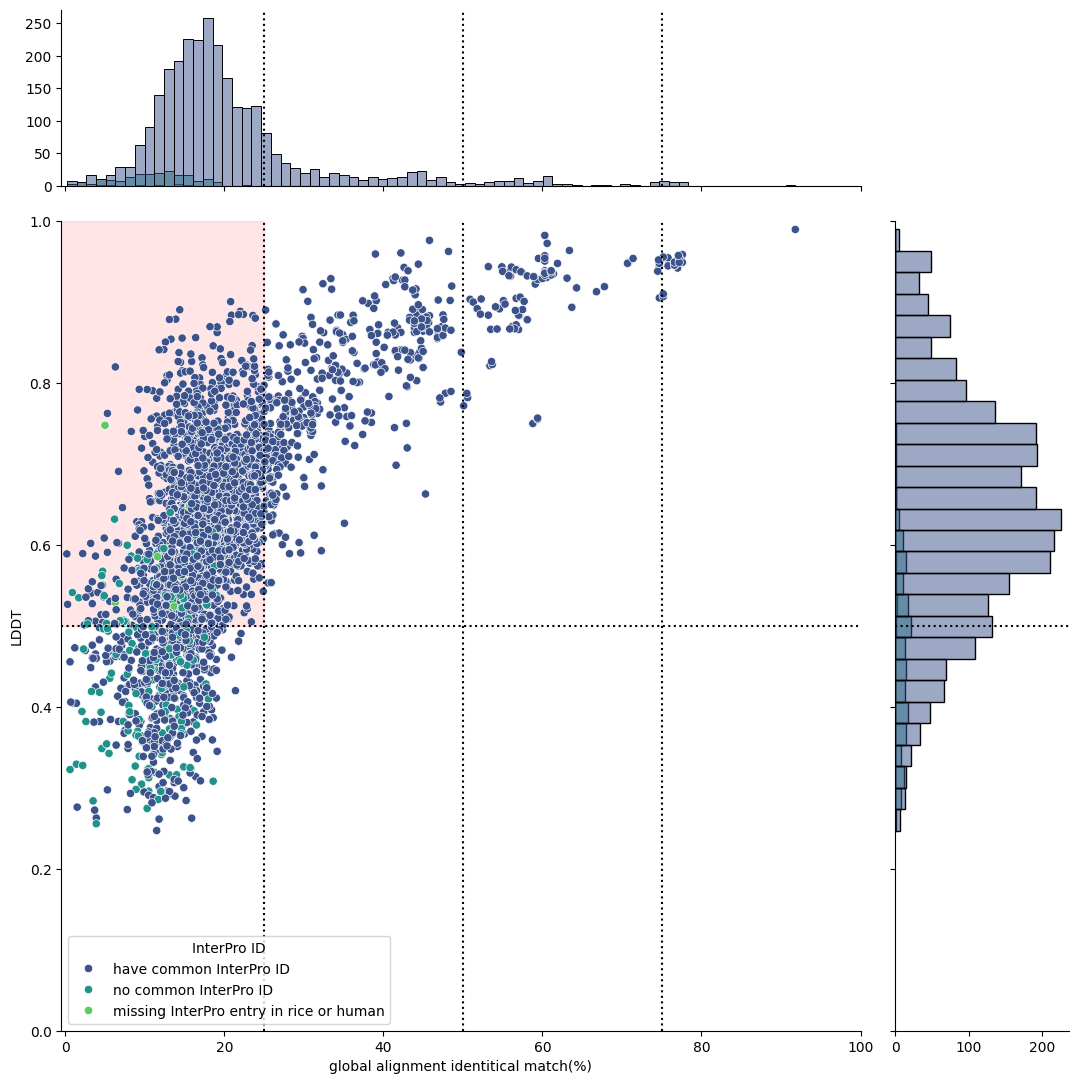

In [35]:
domain_info_viz = domain_info.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water",
    "InterPro ID intersection tag"
).unique().sort(
    by=["From"],
    descending=[False]
)

g = sns.JointGrid(
    data=domain_info_viz,
    x="Identity_percent_needle",
    y="lddt",
    hue="InterPro ID intersection tag",
    height=11,
    dropna=False,
    ratio=4,
    palette="viridis",
    marginal_ticks=True
)
g.ax_joint.set_xlim(-0.5,100)
g.ax_joint.set_ylim(0,1)
g.ax_joint.set_xlabel("global alignment identitical match(%)")
g.ax_joint.set_ylabel("LDDT")

g.ax_joint.fill_betweenx(
    y=[0.5, 1],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

g.refline(x=25, color="black", linestyle=":")
g.refline(x=50, color="black", linestyle=":")
g.refline(x=75, color="black", linestyle=":")
g.refline(y=0.5, color="black", linestyle=":")
g.plot(sns.scatterplot, sns.histplot)

# 呼び出し順に注意!!
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=labels, title='InterPro ID')

plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;





&nbsp;

## Custom Analysis: Ensembl pan-homology information

- Ensembl pan-homologyの情報を追加する

In [36]:
ensembl_pan_homology = pl.read_csv(
    pan_homology_tsv_path,
    separator='\t'
).rename(
    {
        "target_id": "ensembl_gene_id",
        "target_protein_id": "ensembl_protein_id"
    }
).select(
    "From",
    "method_link_type",
    "type",
    "ensembl_gene_id",
    "ensembl_protein_id"
)

print(ensembl_pan_homology.group_by(["From"]).n_unique())
display(ensembl_pan_homology)

shape: (106, 5)
┌──────────────┬──────────────────┬──────┬─────────────────┬────────────────────┐
│ From         ┆ method_link_type ┆ type ┆ ensembl_gene_id ┆ ensembl_protein_id │
│ ---          ┆ ---              ┆ ---  ┆ ---             ┆ ---                │
│ str          ┆ u32              ┆ u32  ┆ u32             ┆ u32                │
╞══════════════╪══════════════════╪══════╪═════════════════╪════════════════════╡
│ Os05g0428600 ┆ 1                ┆ 1    ┆ 5               ┆ 5                  │
│ Os11g0601700 ┆ 1                ┆ 1    ┆ 7               ┆ 7                  │
│ Os01g0719100 ┆ 1                ┆ 1    ┆ 1               ┆ 1                  │
│ Os03g0822700 ┆ 1                ┆ 1    ┆ 1               ┆ 1                  │
│ Os07g0246200 ┆ 1                ┆ 1    ┆ 2               ┆ 2                  │
│ …            ┆ …                ┆ …    ┆ …               ┆ …                  │
│ Os06g0593100 ┆ 1                ┆ 1    ┆ 1               ┆ 1                  │


From,method_link_type,type,ensembl_gene_id,ensembl_protein_id
str,str,str,str,str
"""Os01g0105800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_one2many""","""ENSG00000135070""","""ENSP00000365159"""
"""Os01g0180800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000173110""","""ENSP00000310219"""
"""Os01g0180800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000120694""","""ENSP00000318687"""
"""Os01g0180800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000164070""","""ENSP00000296464"""
"""Os01g0180800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000170606""","""ENSP00000302961"""
…,…,…,…,…
"""Os12g0600100""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000005175""","""ENSP00000005386"""
"""Os12g0600100""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000256061""","""ENSP00000323275"""
"""Os12g0600100""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000115282""","""ENSP00000233623"""


In [37]:
ensembl_pan_homology_info = condition4.with_columns(
    pl.when( # https://docs.pola.rs/api/python/stable/reference/expressions/api/polars.Expr.list.eval.html
        pl.col("ensembl_protein_id").list.eval( 
            pl.element().is_in(ensembl_pan_homology.select("ensembl_protein_id"))
        ).list.any() # check if any of the elements in the list are in the selected column
    ).then(
        pl.lit("ENSEMBL_ORTHOLOGUES")
    ).otherwise(
        None
    ).alias(
        "method_link_type"
    )
).with_columns(
    pl.when(
        (pl.col("method_link_type") == "ENSEMBL_ORTHOLOGUES").any().over("From")
    ).then(
        pl.lit("have ensembl pan-homology info in gene level")
    ).when( # Ensembl pan-homology情報があるが、対応するuniprot idがない場合
        (pl.col("method_link_type").is_null()).any().over("From") &
        (pl.col("From").is_in(ensembl_pan_homology.select("From")))
    ).then(
        pl.lit("have ensembl pan-homology info but no corresponding uniprot id hits")
    ).otherwise(
        pl.lit("no ensembl pan-homology info in gene level")
    ).alias(
        "pan_homology_tag"
    )
)

display(ensembl_pan_homology_info)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,method_link_type,pan_homology_tag
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str],str,str
"""Os01g0105800""","""Q657Z2""","""Q5TBE9""",0.000019,1.0,1,42.8,0.428,36,4,86,138,2,85,86,84,0.601,0.977,0.6491,0.4395,0.6864,0.6864,11.51,9606,"""Homo sapiens""",47,81,141,"""37/81""","""37/141""",45.7,26.2,63.0,36.2,"""6/81""","""58/141""",7.4,41.1,154.5,153.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365157""]",null,"""have ensembl pan-homology info…"
"""Os01g0105800""","""Q657Z2""","""Q9BUE6""",9.1120e-13,1.0,1,51.6,0.516,64,4,126,138,2,125,129,124,0.891,0.961,0.8839,0.7278,0.7768,0.7768,11.57,9606,"""Homo sapiens""",59,128,141,"""67/128""","""67/141""",52.3,47.5,67.2,61.0,"""5/128""","""15/141""",3.9,10.6,316.5,312.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365159""]","""ENSEMBL_ORTHOLOGUES""","""have ensembl pan-homology info…"
"""Os01g0105800""","""Q657Z2""","""A0A1B0GTK6""",2.9110e-9,1.0,1,48.3,0.483,43,27,114,138,4,92,92,89,0.638,0.967,0.841,0.6203,0.9193,0.9193,0.88,9606,"""Homo sapiens""",45,87,141,"""44/87""","""44/141""",50.6,31.2,70.1,43.3,"""5/87""","""52/141""",5.7,36.9,211.5,206.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000489740""]",null,"""have ensembl pan-homology info…"
"""Os01g0105800""","""Q657Z2""","""Q86U28""",2.6130e-8,1.0,3,29.8,0.298,37,4,125,138,27,147,154,124,0.884,0.786,0.7242,0.6192,0.5619,0.5619,8.441,9606,"""Homo sapiens""",82,126,162,"""39/126""","""39/162""",31.0,24.1,50.8,39.5,"""3/126""","""32/162""",2.4,19.8,164.5,154.5,"[""ISCA2"", ""ISCA2""]","[""ENSG00000165898"", ""ENSG00000165898""]","[""ENSP00000450523"", ""ENSP00000452007""]",null,"""have ensembl pan-homology info…"
"""Os01g0135800""","""Q943Q3""","""O14558""",0.01643,1.0,8,18.9,0.189,31,3,145,150,12,160,160,164,0.953,0.931,0.5166,0.4431,0.4175,0.4175,16.35,9606,"""Homo sapiens""",97,119,176,"""30/119""","""35/176""",25.2,19.9,42.9,34.1,"""13/119""","""42/176""",10.9,23.9,71.0,63.0,"[""HSPB6""]","[""ENSG00000004776""]","[""ENSP00000004982""]","""ENSEMBL_ORTHOLOGUES""","""have ensembl pan-homology info…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0600100""","""Q0IM43""","""Q9Y575""",4.1220e-10,1.0,21,17.6,0.176,91,8,386,387,13,506,518,516,0.979,0.954,0.5381,0.4101,0.3225,0.3225,22.4,9606,"""Homo sapiens""",266,272,596,"""84/272""","""110/596""",30.9,18.5,48.5,28.0,"""49/272""","""287/596""",18.0,48.2,275.5,266.0,"[""ASB3"", ""ASB3"", … ""ASB3""]","[""ENSG00000115239"", ""ENSG00000115239"", … ""ENSG00000115239""]","[""ENSP00000263634"", ""ENSP00000378206"", … ""ENSP00000384728""]",null,"""have ensembl pan-homology info…"
"""Os12g0600100""","""Q0IM43""","""H7C209""",2.3270e-8,1.0,20,18.3,0.183,87,9,382,387,40,471,791,474,0.966,0.546,0.5753,0.5132,0.2568,0.2568,14.99,9606,"""Homo sapiens""",245,427,848,"""100/427""","""112/848""",23.4,13.2,36.3,19.9,"""114/427""","""518/848""",26.7,61.1,230.5,217.5,"[""ANKRD44""]","[""ENSG00000065413""]","[""ENSP00000403415""]",null,"""have ensembl pan-homology info…"
"""Os12g0600100""","""Q2QML3""","""A0A3B3ITU5""",4.7260e-7,1.0,7,22.3,0.223,62,9,260,387,84,339,455,278,0.651,0.563,0.6766,0.5119,0.4378,0.4378,8.868,9606,"""Homo sapiens""",168,354,588,"""90/354""","""86/588""",25.4,14.6,38.1,23.0,"""93/354""","""334/588""",26.3,56.8,197.0,178.5,"[""ANKS1A""]","[""ENSG00000064999""]","[""ENSP00000497939""]",null,"""have e

In [38]:
ensembl_pan_homology_info_filter = ensembl_pan_homology_info.filter(
    (pl.col("pan_homology_tag") == "have ensembl pan-homology info in gene level") |
    (pl.col("pan_homology_tag") == "have ensembl pan-homology info but no corresponding uniprot id hits")
)

display(ensembl_pan_homology_info_filter)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,method_link_type,pan_homology_tag
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str],str,str
"""Os01g0105800""","""Q657Z2""","""Q5TBE9""",0.000019,1.0,1,42.8,0.428,36,4,86,138,2,85,86,84,0.601,0.977,0.6491,0.4395,0.6864,0.6864,11.51,9606,"""Homo sapiens""",47,81,141,"""37/81""","""37/141""",45.7,26.2,63.0,36.2,"""6/81""","""58/141""",7.4,41.1,154.5,153.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365157""]",null,"""have ensembl pan-homology info…"
"""Os01g0105800""","""Q657Z2""","""Q9BUE6""",9.1120e-13,1.0,1,51.6,0.516,64,4,126,138,2,125,129,124,0.891,0.961,0.8839,0.7278,0.7768,0.7768,11.57,9606,"""Homo sapiens""",59,128,141,"""67/128""","""67/141""",52.3,47.5,67.2,61.0,"""5/128""","""15/141""",3.9,10.6,316.5,312.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000365159""]","""ENSEMBL_ORTHOLOGUES""","""have ensembl pan-homology info…"
"""Os01g0105800""","""Q657Z2""","""A0A1B0GTK6""",2.9110e-9,1.0,1,48.3,0.483,43,27,114,138,4,92,92,89,0.638,0.967,0.841,0.6203,0.9193,0.9193,0.88,9606,"""Homo sapiens""",45,87,141,"""44/87""","""44/141""",50.6,31.2,70.1,43.3,"""5/87""","""52/141""",5.7,36.9,211.5,206.5,"[""ISCA1""]","[""ENSG00000135070""]","[""ENSP00000489740""]",null,"""have ensembl pan-homology info…"
"""Os01g0105800""","""Q657Z2""","""Q86U28""",2.6130e-8,1.0,3,29.8,0.298,37,4,125,138,27,147,154,124,0.884,0.786,0.7242,0.6192,0.5619,0.5619,8.441,9606,"""Homo sapiens""",82,126,162,"""39/126""","""39/162""",31.0,24.1,50.8,39.5,"""3/126""","""32/162""",2.4,19.8,164.5,154.5,"[""ISCA2"", ""ISCA2""]","[""ENSG00000165898"", ""ENSG00000165898""]","[""ENSP00000450523"", ""ENSP00000452007""]",null,"""have ensembl pan-homology info…"
"""Os01g0135800""","""Q943Q3""","""O14558""",0.01643,1.0,8,18.9,0.189,31,3,145,150,12,160,160,164,0.953,0.931,0.5166,0.4431,0.4175,0.4175,16.35,9606,"""Homo sapiens""",97,119,176,"""30/119""","""35/176""",25.2,19.9,42.9,34.1,"""13/119""","""42/176""",10.9,23.9,71.0,63.0,"[""HSPB6""]","[""ENSG00000004776""]","[""ENSP00000004982""]","""ENSEMBL_ORTHOLOGUES""","""have ensembl pan-homology info…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0600100""","""Q0IM43""","""Q9Y575""",4.1220e-10,1.0,21,17.6,0.176,91,8,386,387,13,506,518,516,0.979,0.954,0.5381,0.4101,0.3225,0.3225,22.4,9606,"""Homo sapiens""",266,272,596,"""84/272""","""110/596""",30.9,18.5,48.5,28.0,"""49/272""","""287/596""",18.0,48.2,275.5,266.0,"[""ASB3"", ""ASB3"", … ""ASB3""]","[""ENSG00000115239"", ""ENSG00000115239"", … ""ENSG00000115239""]","[""ENSP00000263634"", ""ENSP00000378206"", … ""ENSP00000384728""]",null,"""have ensembl pan-homology info…"
"""Os12g0600100""","""Q0IM43""","""H7C209""",2.3270e-8,1.0,20,18.3,0.183,87,9,382,387,40,471,791,474,0.966,0.546,0.5753,0.5132,0.2568,0.2568,14.99,9606,"""Homo sapiens""",245,427,848,"""100/427""","""112/848""",23.4,13.2,36.3,19.9,"""114/427""","""518/848""",26.7,61.1,230.5,217.5,"[""ANKRD44""]","[""ENSG00000065413""]","[""ENSP00000403415""]",null,"""have ensembl pan-homology info…"
"""Os12g0600100""","""Q2QML3""","""A0A3B3ITU5""",4.7260e-7,1.0,7,22.3,0.223,62,9,260,387,84,339,455,278,0.651,0.563,0.6766,0.5119,0.4378,0.4378,8.868,9606,"""Homo sapiens""",168,354,588,"""90/354""","""86/588""",25.4,14.6,38.1,23.0,"""93/354""","""334/588""",26.3,56.8,197.0,178.5,"[""ANKS1A""]","[""ENSG00000064999""]","[""ENSP00000497939""]",null,"""have e

&nbsp;

&nbsp;

&nbsp;

&nbsp;


# Custom Analysis: HN-score information

- HN-scoreの情報を追加する
- サンプルごとに算出したHN-scoreのデータを追加する

In [39]:
HNscore_rice_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_validate_HN5_rice.tsv",
    separator='\t'
).rename(
    {
        "GENEID": "From"
    }
).drop(
    "positive_contribution",
    "negative_contribution"
)

display(HNscore_rice_sample)

From,HN5(all),positive_samples_count,negative_samples_count,total_samples
str,i64,i64,i64,i64
"""Os04g0107900""",255,13,2,15
"""Os01g0136100""",245,12,1,15
"""Os02g0259900""",238,10,1,15
"""Os02g0259850""",237,11,2,15
"""Os03g0245800""",237,9,2,15
…,…,…,…,…
"""Os01g0952800""",-173,1,10,15
"""Os07g0142100""",-176,1,7,15
"""Os03g0307200""",-180,2,7,15


In [40]:
hnscore_rice_info = condition4.join(
    HNscore_rice_sample,
    on="From",
    how="left",
    coalesce=True
).sort(
    by=["HN5(all)"],
    descending=True
)

display(hnscore_rice_info)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,HN5(all),positive_samples_count,negative_samples_count,total_samples
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str],i64,i64,i64,i64
"""Os04g0107900""","""A0A0P0W604""","""Q5XG96""",0.02751,0.988,13,15.0,0.15,25,30,188,249,2,153,165,166,0.639,0.921,0.3813,0.3267,0.4676,0.4676,10.83,9606,"""Homo sapiens""",120,165,274,"""35/165""","""44/274""",21.2,16.1,40.0,26.3,"""44/165""","""134/274""",26.7,48.9,53.0,44.0,"[""PMS1""]","[""ENSG00000064933""]","[""ENSP00000363959""]",255,13,2,15
"""Os04g0107900""","""A0A0P0W604""","""G3V2J8""",9.8510e-15,1.0,1,45.6,0.456,109,1,239,249,6,174,174,239,0.96,0.971,0.6628,0.5991,0.844,0.844,6.402,9606,"""Homo sapiens""",60,228,254,"""111/228""","""115/254""",48.7,45.3,59.6,55.5,"""70/228""","""85/254""",30.7,33.5,532.5,526.0,"[""HSP90AA1""]","[""ENSG00000080824""]","[""ENSP00000450712""]",255,13,2,15
"""Os04g0107900""","""A0A0P0W604""","""A0A7P0TBC2""",1.2810e-24,1.0,4,50.3,0.503,129,13,249,249,74,326,465,256,0.952,0.544,0.7082,0.7009,0.3834,0.3834,12.37,9606,"""Homo sapiens""",105,259,468,"""135/259""","""137/468""",52.1,29.3,69.9,40.0,"""24/259""","""222/468""",9.3,47.4,645.0,640.5,"[""HSP90B1""]","[""ENSG00000166598""]","[""ENSP00000506602""]",255,13,2,15
"""Os04g0107900""","""A0A0P0W604""","""G3V3E0""",0.0001617,1.0,11,19.7,0.197,36,29,201,249,2,161,162,182,0.695,0.988,0.398,0.3344,0.4906,0.4906,10.15,9606,"""Homo sapiens""",115,148,257,"""27/148""","""34/257""",18.2,13.2,36.5,24.9,"""23/148""","""103/257""",15.5,40.1,51.5,39.5,"[""MLH3""]","[""ENSG00000119684""]","[""ENSP00000451192""]",255,13,2,15
"""Os04g0107900""","""A0A0P0W604""","""A0A7P0T8R3""",1.1910e-19,1.0,3,55.8,0.558,101,11,186,249,72,251,251,181,0.707,0.717,0.7605,0.6648,0.6597,0.6597,1.803,9606,"""Homo sapiens""",74,182,315,"""104/182""","""105/315""",57.1,33.3,73.6,43.8,"""7/182""","""130/315""",3.8,41.3,503.5,498.5,"[""HSP90B1""]","[""ENSG00000166598""]","[""ENSP00000505280""]",255,13,2,15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os05g0460475""","""A0A0P0WN72""","""Q16777""",0.03458,1.0,2,22.6,0.226,22,1,90,106,2,96,129,97,0.849,0.736,0.7261,0.5961,0.5078,0.5078,3.56,9606,"""Homo sapiens""",66,87,129,"""19/87""","""27/129""",21.8,20.9,46.0,40.3,"""7/87""","""23/129""",8.0,17.8,57.0,53.5,"[""H2AC20""]","[""ENSG00000184260""]","[""ENSP00000332194""]",42,12,2,15
"""Os08g0374600""","""A0A0P0XF07""","""A0A286YEV3""",0.003908,0.999,15,16.2,0.162,35,7,167,195,60,252,346,216,0.826,0.558,0.4727,0.3833,0.2286,0.2286,13.14,9606,"""Homo sapiens""",103,170,392,"""41/170""","""50/392""",24.1,12.8,35.3,20.2,"""63/170""","""243/392""",37.1,62.0,58.5,42.0,"[""MAPK10""]","[""ENSG00000109339""]","[""ENSP00000492967""]",42,8,5,15
"""Os08g0374600""","""A0A0P0XF07""","""Q9NSY0""",0.006278,0.996,13,12.5,0.125,35,10,191,195,42,301,501,278,0.933,0.519,0.4634,0.3635,0.1639,0.1639,15.29,9606,"""Homo sapiens""",129,109,587,"""27/109""","""30/587""",24.8,5.1,34.9,7.3,"""21/109""","""478/587""",19.3,81.4,38.5,26.5,"[""NRBP2""]","[""ENSG00000185189""]","[""ENSP00000414055""]",42,8,5,15


&nbsp;

&nbsp;

- 先に、foldseekでヒットしたUniProt IDに対応するデータをフィルタリングしておく

In [41]:
HNscore_human_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_human_checked_up.tsv",
    separator="\t"
).drop(
    "positive_contribution_human",
    "negative_contribution_human"
)

HNscore_mouse_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_mouse_checked_up.tsv",
    separator="\t"
).drop(
    "positive_contribution_mouse",
    "negative_contribution_mouse"
)

display(HNscore_human_sample.head())
display(HNscore_mouse_sample.head())

uniprot_id,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,GENEID,HN5(all),positive_samples_count_human,negative_samples_count_human,total_samples
str,str,str,str,i64,str,i64,i64,i64,i64
"""P17066""","""ENSP00000310219""","""ENST00000309758""","""ENSG00000173110""",5239,"""HSPA6""",245,27,0,30
"""P0DMV8""","""ENSP00000364802""","""ENST00000375651""","""ENSG00000204389""",5232,"""HSPA1A""",239,27,0,30
"""P0DMV8""","""ENSP00000382915""","""ENST00000400040""","""ENSG00000215328""",5232,"""HSPA1A""",239,27,0,30
"""P0DMV8""","""ENSP00000404524""","""ENST00000430065""","""ENSG00000235941""",5232,"""HSPA1A""",239,27,0,30
"""P0DMV8""","""ENSP00000408907""","""ENST00000433487""","""ENSG00000234475""",5232,"""HSPA1A""",239,27,0,30


uniprot_id,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,mgi_gene_id,Mouse Gene ID,GENEID,HN5(all),positive_samples_count_mouse,negative_samples_count_mouse,total_samples
str,str,str,str,i64,i64,str,str,i64,i64,i64,i64
"""A0A0G2JIW1""","""ENSP00000387691""","""ENST00000417199""","""ENSG00000232804""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""A0A0G2JIW1""","""ENSP00000402651""","""ENST00000458062""","""ENSG00000212866""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""A0A0G2JIW1""","""ENSP00000442789""","""ENST00000545241""","""ENSG00000224501""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""P0DMV9""","""ENSP00000364801""","""ENST00000375650""","""ENSG00000204388""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""P0DMV9""","""ENSP00000375399""","""ENST00000391555""","""ENSG00000212866""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30


In [42]:
HNscore_hm_combine = HNscore_human_sample.join(
    HNscore_mouse_sample,
    on=["uniprot_id", "ensembl_protein_id", "ensembl_transcript_id", "ensembl_gene_id", "hgnc_id"],
    how="left",
    coalesce=True,
    suffix="_mouse"
).select(
    [
        "uniprot_id",
        "ensembl_protein_id",
        "ensembl_transcript_id",
        "ensembl_gene_id",
        "hgnc_id",
        "GENEID",
        "mgi_gene_id",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_mouse",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "total_samples",
        "total_samples_mouse"
    ]
).rename(
    {
        "uniprot_id": "foldseek hit",
        "GENEID": "hgnc_symbol_id",
        "HN5(all)": "HN5(all)_human",
        "total_samples": "total_samples_human"
    }
).unique().sort(
    by=["HN5(all)_human", "HN5(all)_mouse"],
    descending=[True, True]
).filter(
    (pl.col("HN5(all)_human").is_not_null()) &
    (pl.col("HN5(all)_mouse").is_not_null())
).group_by(
    pl.exclude(
        [
            "ensembl_protein_id", "ensembl_transcript_id", "ensembl_gene_id", "hgnc_id", "mgi_gene_id", "hgnc_symbol_id", "GENEID_mouse"
        ]
    )
).agg(
    pl.col("ensembl_protein_id"),
    pl.col("ensembl_transcript_id"),
    pl.col("ensembl_gene_id"),
    pl.col("hgnc_symbol_id"),
    pl.col("GENEID_mouse")
).drop(
    "ensembl_transcript_id"
)

display(HNscore_hm_combine)

foldseek hit,HN5(all)_human,HN5(all)_mouse,positive_samples_count_human,positive_samples_count_mouse,negative_samples_count_human,negative_samples_count_mouse,total_samples_human,total_samples_mouse,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,GENEID_mouse
str,i64,i64,i64,i64,i64,i64,i64,i64,list[str],list[str],list[str],list[str]
"""O14787""",5,-1,3,2,2,2,30,30,"[""ENSP00000407182"", ""ENSP00000397379"", … ""ENSP00000349321""]","[""ENSG00000105576"", ""ENSG00000105576"", … ""ENSG00000105576""]","[""TNPO2"", ""TNPO2"", … ""TNPO2""]","[""Tnpo2"", ""Tnpo2"", … ""Tnpo2""]"
"""I3L0N3""",6,-4,5,4,1,1,30,30,"[""ENSP00000460152"", ""ENSP00000516376"", … ""ENSP00000486150""]","[""ENSG00000073969"", ""ENSG00000073969"", … ""ENSG00000278174""]","[""NSF"", ""NSF"", … ""NSF""]","[""Nsf"", ""Nsf"", … ""Nsf""]"
"""F5H5A1""",-4,-2,2,2,6,2,30,30,"[""ENSP00000367596""]","[""ENSG00000176715""]","[""ACSF3""]","[""Acsf3""]"
"""Q63ZE4""",1,1,1,1,1,0,30,30,"[""ENSP00000327569""]","[""ENSG00000184999""]","[""SLC22A10""]","[""Slc22a28""]"
"""A0A7P0TAE1""",13,-1,6,4,1,2,30,30,"[""ENSP00000506150""]","[""ENSG00000166598""]","[""HSP90B1""]","[""Hsp90b1""]"
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q4VXU2""",0,-4,2,2,4,4,30,30,"[""ENSP00000255136"", ""ENSP00000445661""]","[""ENSG00000101104"", ""ENSG00000101104""]","[""PABPC1L"", ""PABPC1L""]","[""Pabpc1l"", ""Pabpc1l""]"
"""O43324""",4,-7,4,2,1,3,30,30,"[""ENSP00000369038"", ""ENSP00000414363""]","[""ENSG00000124802"", ""ENSG00000124802""]","[""EEF1E1"", ""EEF1E1""]","[""Eef1e1"", ""Eef1e1""]"
"""Q9H2K2""",5,-2,3,3,1,3,30,30,"[""ENSP00000360689""]","[""ENSG00000107854""]","[""TNKS2""]","[""Tnks2""]"


&nbsp;

&nbsp;

In [43]:
hnscore_info = hnscore_rice_info.join(
    HNscore_hm_combine,
    on=["foldseek hit", "ensembl_protein_id", "ensembl_gene_id", "hgnc_symbol_id"], # data type is list[str]
    how="left",
    coalesce=True
).filter(
    pl.col("HN5(all)_human").is_not_null() &
    pl.col("HN5(all)_mouse").is_not_null()
).with_columns(
    (pl.col("positive_samples_count") + pl.col("positive_samples_count_human") + pl.col("positive_samples_count_mouse")).alias("positive_samples_count_all"),
    (pl.col("negative_samples_count") + pl.col("negative_samples_count_human") + pl.col("negative_samples_count_mouse")).alias("negative_samples_count_all")
).select(
    [
        "From",
        "UniProt Accession",
        "foldseek hit",
        "hgnc_symbol_id",
        "ensembl_gene_id",
        "ensembl_protein_id",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_human",
        "HN5(all)_mouse",
        "positive_samples_count",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "total_samples",
        "total_samples_human",
        "total_samples_mouse",
        "positive_samples_count_all",
        "negative_samples_count_all"
    ]
).sort(
    by=["positive_samples_count_all", "negative_samples_count_all"],
    descending=[True, True]
).filter(
    (pl.col("positive_samples_count") >= 5) &
    (pl.col("positive_samples_count_human") >= 5) &
    (pl.col("positive_samples_count_mouse") >= 5)
)

display(hnscore_info)

From,UniProt Accession,foldseek hit,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,GENEID_mouse,HN5(all),HN5(all)_human,HN5(all)_mouse,positive_samples_count,positive_samples_count_human,positive_samples_count_mouse,negative_samples_count,negative_samples_count_human,negative_samples_count_mouse,total_samples,total_samples_human,total_samples_mouse,positive_samples_count_all,negative_samples_count_all
str,str,str,list[str],list[str],list[str],list[str],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Os01g0136100""","""P27777""","""A0A6Q8PGK1""","[""HSPB1""]","[""ENSG00000106211""]","[""ENSP00000502249""]","[""Hspb1""]",245,112,111,12,22,22,1,0,1,15,30,30,56,2
"""Os01g0136100""","""P27777""","""P04792""","[""HSPB1""]","[""ENSG00000106211""]","[""ENSP00000248553""]","[""Hspb1""]",245,112,111,12,22,22,1,0,1,15,30,30,56,2
"""Os01g0136100""","""P27777""","""A0A6Q8PFK8""","[""HSPB1""]","[""ENSG00000106211""]","[""ENSP00000501831""]","[""Hspb1""]",245,112,111,12,22,22,1,0,1,15,30,30,56,2
"""Os02g0782500""","""Q6K7E9""","""P04792""","[""HSPB1""]","[""ENSG00000106211""]","[""ENSP00000248553""]","[""Hspb1""]",154,112,111,11,22,22,4,0,1,15,30,30,55,5
"""Os02g0782500""","""Q6K7E9""","""A0A6Q8PFK8""","[""HSPB1""]","[""ENSG00000106211""]","[""ENSP00000501831""]","[""Hspb1""]",154,112,111,11,22,22,4,0,1,15,30,30,55,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os10g0320100""","""Q7G602""","""A0A0A0MQR0""","[""CYP4F2""]","[""ENSG00000186115""]","[""ENSP00000011989""]","[""Cyp4f18""]",56,6,0,5,6,6,7,1,4,15,30,30,17,12
"""Os10g0320100""","""Q7G602""","""P33261""","[""CYP2C19""]","[""ENSG00000165841""]","[""ENSP00000360372""]","[""Cyp2c50""]",56,11,6,5,7,5,7,0,0,15,30,30,17,7
"""Os08g0557800""","""Q6ZJ06""","""P26439""","[""HSD3B2"", ""HSD3B2""]","[""ENSG00000203859"", ""ENSG00000203859""]","[""ENSP00000358424"", ""ENSP00000445122""]","[""Hsd3b3"", ""Hsd3b3""]",62,8,6,5,7,5,0,0,0,15,30,30,17,0


&nbsp;

&nbsp;

&nbsp;


In [46]:
foldseek_contents = {
    "foldseek hit": condition4["From"].unique().sort().to_list(),
    "LDDT ≧ 0.5 & Identity ≦ 25%": condition4_filter["From"].unique().sort().to_list(),
    "LDDT ≧ 0.5 & Identity > 25%": condition4_filter_1["From"].unique().sort().to_list(),
    "Common InterPro ID": have_domain_info["From"].unique().sort().to_list(),
    "Ensembl pan-homology": ensembl_pan_homology_info_filter["From"].unique().sort().to_list(),
    "HN-score sample contribution": hnscore_info["From"].unique().sort().to_list()
}

upset_data = from_contents(foldseek_contents)
display(upset_data)

/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
foldseek hit LDDT ≧ 0.5 & Identity ≦ 25% LDDT ≧ 0.5 & Identity > 25% Common InterPro ID Ensembl pan-homology HN-score sample contribution              
True         False                       True                        True               True                 False                         Os01g0105800
             True                        False                       True               True                 True                          Os01g0135800
                                                                                                             True                          Os01g0136000
                                                                                                             True                          Os01g0136100
                                                                                                             True                          Os01g0136200
...                                                                                                                                                 ...
                                                                                                             False                         Os11g0601700
             False                       True                        True               True                 False                         Os12g0106000
                                                                                                             True                          Os12g0270900
             True                        False                       True               False                False                         Os12g0478200
                                                                                        True                 True                          Os12g0600100

[144 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

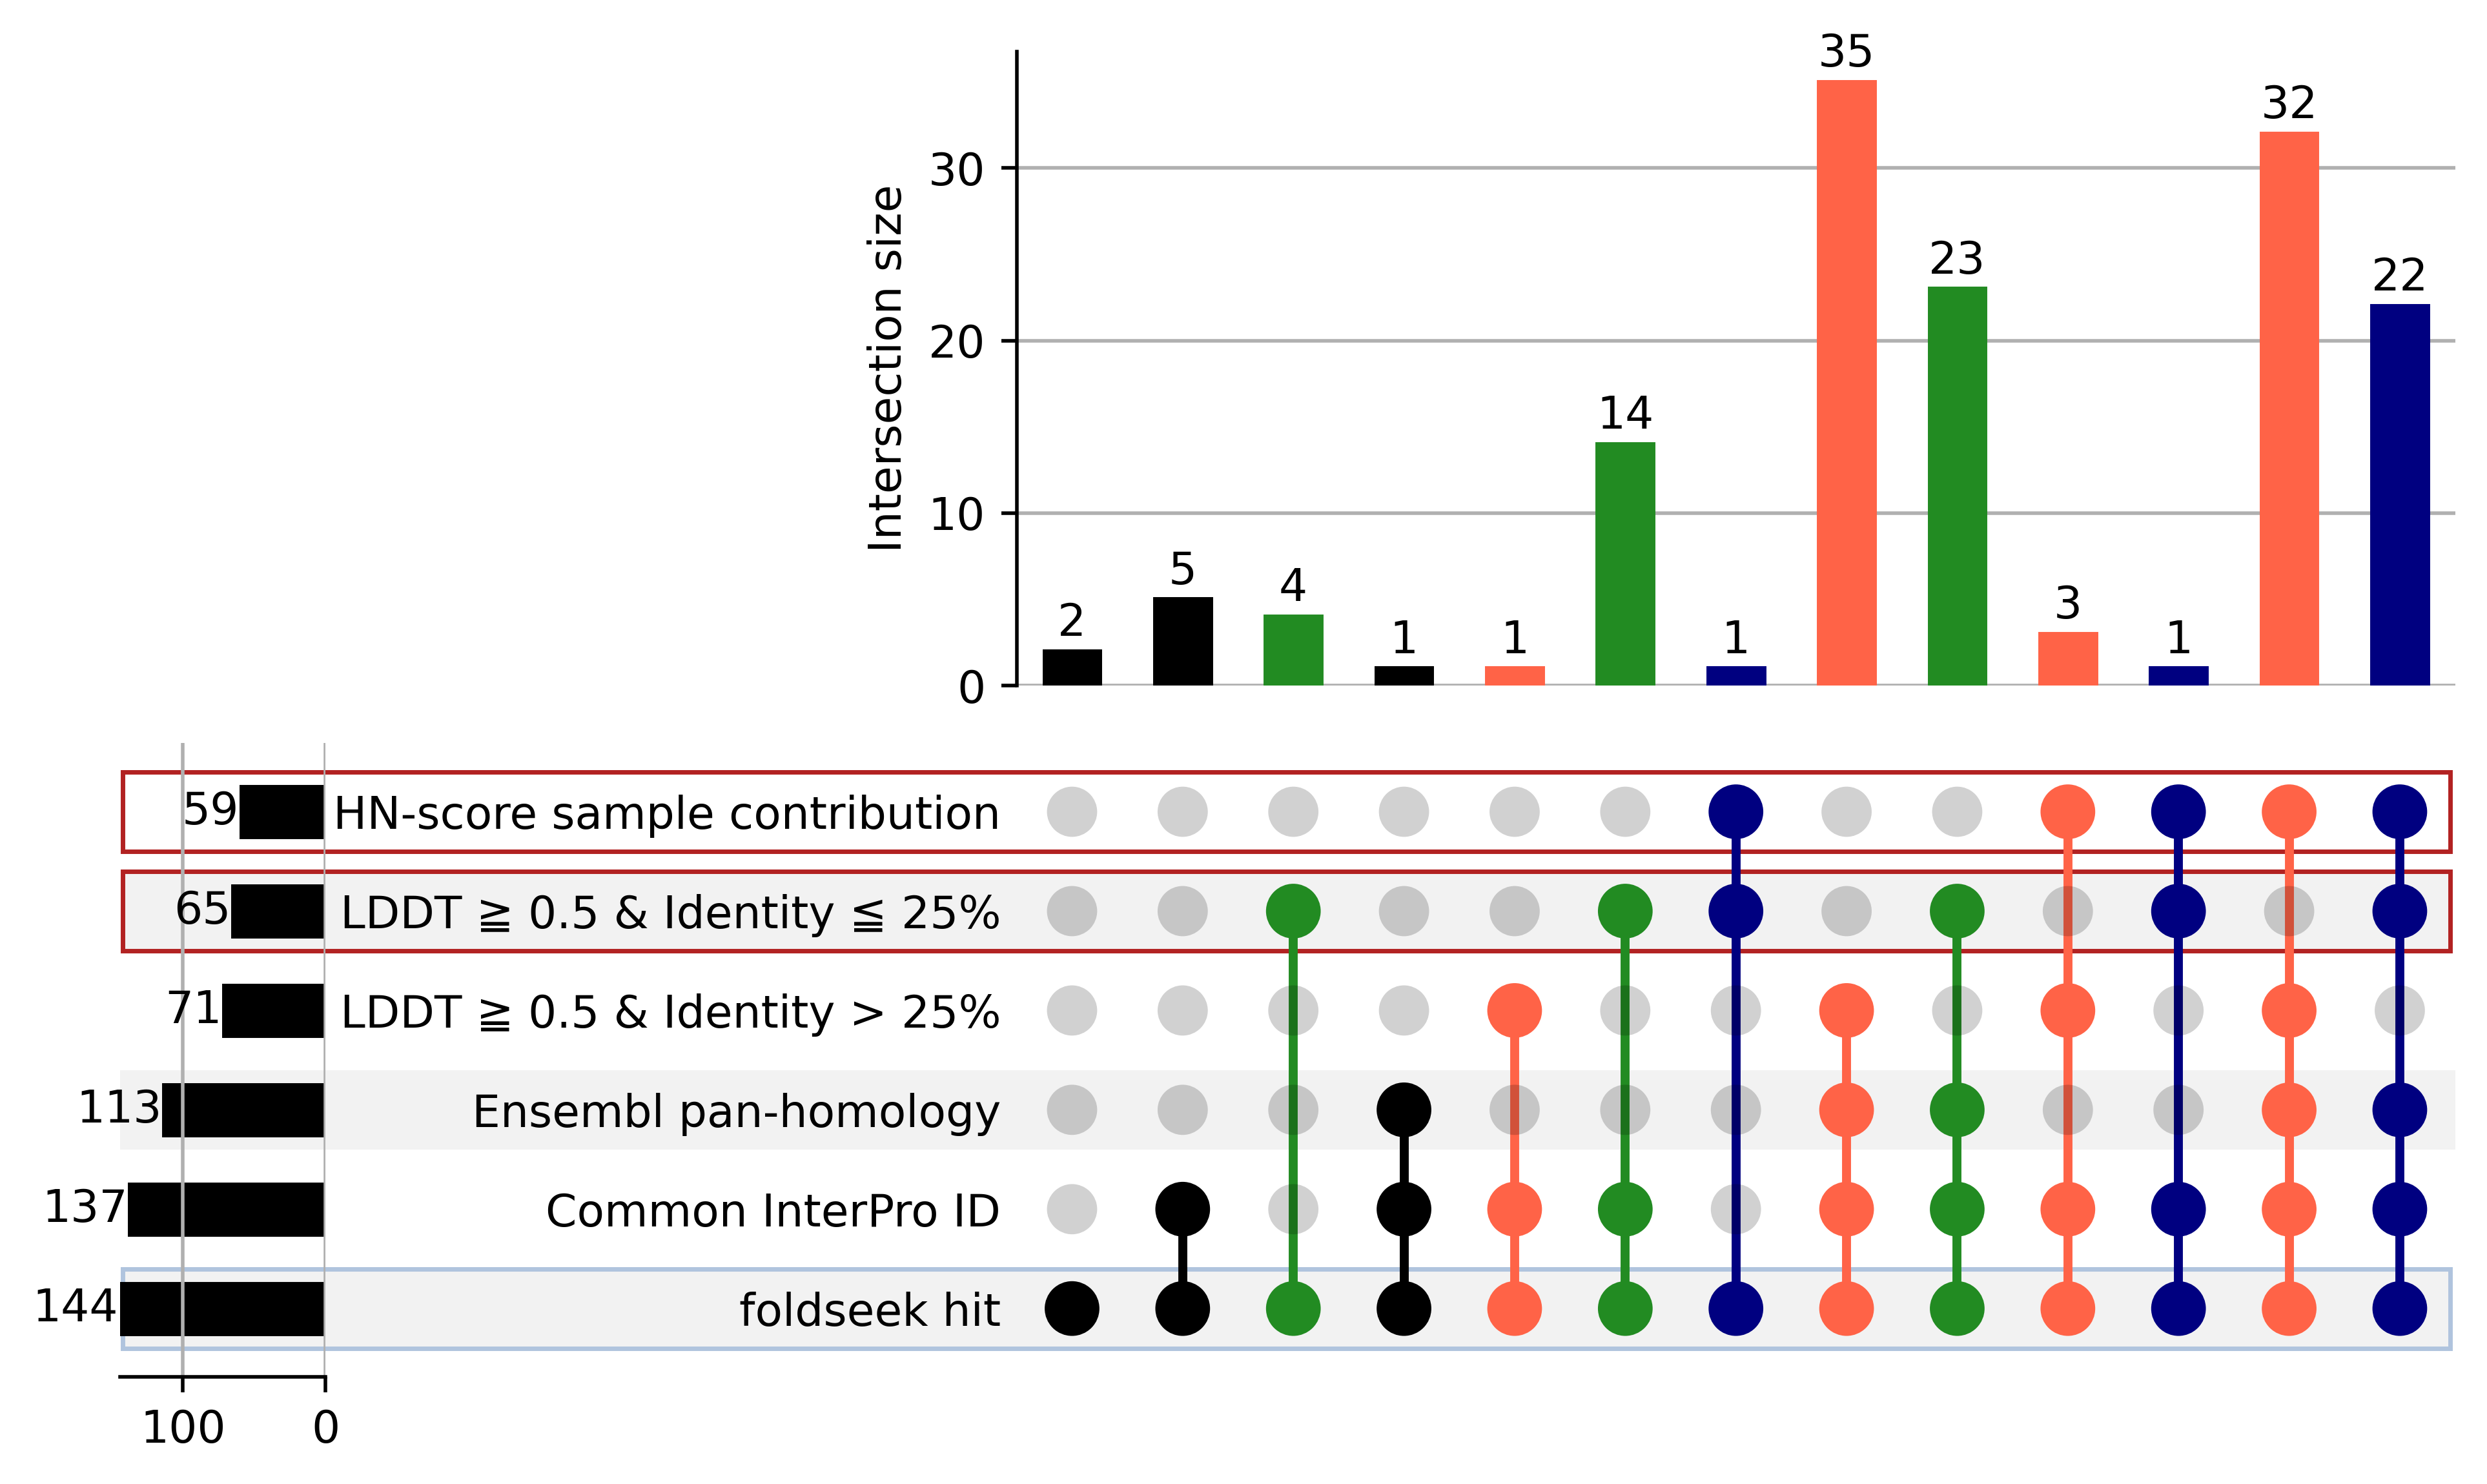

In [61]:
upset_plot = UpSet(
    upset_data,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(
    present=["LDDT ≧ 0.5 & Identity ≦ 25%", "HN-score sample contribution"], 
    facecolor="navy"
)

upset_plot.style_subsets(
    present=["LDDT ≧ 0.5 & Identity ≦ 25%"],
    absent=["HN-score sample contribution"], 
    facecolor="forestgreen"
)

upset_plot.style_subsets(
    present=["LDDT ≧ 0.5 & Identity > 25%"],
    facecolor="tomato"
)

upset_plot.style_categories(
    "foldseek hit",
    shading_edgecolor="lightsteelblue",
)

upset_plot.style_categories(
    "HN-score sample contribution",
    shading_edgecolor="firebrick",
)

upset_plot.style_categories(
    "LDDT ≧ 0.5 & Identity ≦ 25%",
    shading_edgecolor="firebrick",
)

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()